In [33]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
from math import sqrt
from bayes_opt import BayesianOptimization
import numpy as np
import matplotlib.pyplot as plt


Importer des données

In [34]:

data=pd.read_csv("../laboratory.csv")

In [35]:
data.head()

TypPS  oxygen   pm10  cnt0_5     co  temperature  performance      co2  \
0  14.966  20.688  0.007   4.867  1.522       20.867        910.0  548.505   
1  14.996  20.687  0.001   3.496  1.521       20.865        915.0  543.500   
2  15.000  20.687  0.000   5.134  1.521       20.866        916.0  542.134   
3  14.081  20.688  0.213   4.223  1.521       20.864        918.0  539.314   
4  14.258  20.687  0.152   8.701  1.522       20.867        915.0  543.551   

   measuretime     so2  ...  health  temperature_o2 cnt2_5      o3  humidity  \
0         1876  38.461  ...   968.0          24.841  0.014  11.550    44.833   
1         1887  38.462  ...   942.0          24.845  0.002  11.520    44.784   
2         1858  38.463  ...   938.0          24.834  0.000  11.506    44.768   
3         1856  38.462  ...   936.0          24.834  0.618  11.438    44.766   
4         1862  38.462  ...   935.0          24.838  0.543  11.393    44.768   

   dHdt  humidity_abs   sound  pm2_5  cnt0_3  
0 -0.03         8.182  21.999    0.0  16.234  
1 -0.06         8.172  24.962    0.0  14.324  
2 -0.07         8.170  25.293    0.0  15.826  
3 -0.04         8.169  26.403    0.0  12.719  
4  0.00         8.170  25.934    0.0  26.107  

[5 rows x 31 columns]

In [36]:
data.tail()

TypPS  oxygen   pm10   cnt0_5     co  temperature  performance  \
51181  2.257  20.906  4.770  227.998  1.530       24.533        798.0   
51182  1.920  20.906  4.169  229.625  1.529       24.546        782.0   
51183  1.688  20.907  5.038  228.146  1.529       24.572        772.0   
51184  1.515  20.905  5.092  246.341  1.530       24.590        761.0   
51185  1.225  20.907  4.216  229.139  1.532       24.614        758.0   

           co2  measuretime      so2  ...  health  temperature_o2 cnt2_5  \
51181  517.499         2046  176.872  ...   820.0          28.700  0.958   
51182  524.201         2088  177.372  ...   844.0          28.721  0.405   
51183  516.942         1827  173.799  ...   803.0          28.757  0.529   
51184  517.797         1828  167.632  ...   790.0          28.797  0.394   
51185  512.732         1999  162.133  ...   822.0          28.815  0.840   

           o3  humidity  dHdt  humidity_abs   sound  pm2_5   cnt0_3  
51181  28.679    39.472 -0.18         8.888  66.425  4.150  710.289  
51182  28.932    39.171 -0.30         8.826  65.066  3.800  725.006  
51183  29.264    38.641 -0.56         8.720  62.035  4.670  721.098  
51184  29.504    38.329 -0.63         8.658  65.898  4.789  780.604  
51185  29.658    38.106 -0.60         8.619  64.354  4.177  726.724  

[5 rows x 31 columns]

Les données sont de 12445x31 et nous devons filtrer les valeurs nulles et les paramètres de mesure qui ne nous concernent pas.

In [37]:
print(data)

        TypPS  oxygen   pm10   cnt0_5     co  temperature  performance  \
0      14.966  20.688  0.007    4.867  1.522       20.867        910.0   
1      14.996  20.687  0.001    3.496  1.521       20.865        915.0   
2      15.000  20.687  0.000    5.134  1.521       20.866        916.0   
3      14.081  20.688  0.213    4.223  1.521       20.864        918.0   
4      14.258  20.687  0.152    8.701  1.522       20.867        915.0   
...       ...     ...    ...      ...    ...          ...          ...   
51181   2.257  20.906  4.770  227.998  1.530       24.533        798.0   
51182   1.920  20.906  4.169  229.625  1.529       24.546        782.0   
51183   1.688  20.907  5.038  228.146  1.529       24.572        772.0   
51184   1.515  20.905  5.092  246.341  1.530       24.590        761.0   
51185   1.225  20.907  4.216  229.139  1.532       24.614        758.0   

           co2  measuretime      so2  ...  health  temperature_o2 cnt2_5  \
0      548.505         1876   38.46

**Nettoyage des données**

Supprimer les lignes nulles et les colonnes de caractéristiques inintéressantes

In [38]:

data.drop(['TypPS', 'cnt0_5','cnt1','performance','measuretime','temperature_o2','sound_max','cnt5','cnt10','dCO2dt','health','cnt2_5','humidity_abs','dHdt','cnt0_3'], axis=1, inplace=True)
data.dropna(inplace=True)
data['timestamp'] = pd.to_datetime(data['timestamp'])

start_date = '2023-04-19'
end_date = '2023-06-03'
data = data[(data['timestamp'] >= start_date) & (data['timestamp'] <= end_date)]
# dates_to_remove = ['2023-04-17', '2023-05-21']
# dates_to_remove = pd.to_datetime(dates_to_remove)
# data = data[~data['timestamp'].dt.normalize().isin(dates_to_remove)]
# data = data[(data != 0).all(axis=1)]
columns = list(data.columns)
columns.remove('temperature')
columns.remove('pressure')
columns.remove('humidity')
columns.extend(['temperature', 'pressure', 'humidity'])

data = data[columns]
print(data)

       oxygen    pm10     co      co2       so2     no2           timestamp  \
18440  20.789   9.315  1.735  507.934  2216.850  21.831 2023-04-19 11:39:01   
18441  20.790   9.040  1.730  504.029  2216.820  21.776 2023-04-19 11:41:03   
18442  20.789  10.338  1.726  503.302  2216.730  22.191 2023-04-19 11:43:05   
18443  20.793   9.173  1.723  503.272  2216.770  23.159 2023-04-19 11:45:06   
18444  20.792   8.218  1.720  503.708  2216.800  24.173 2023-04-19 11:47:08   
...       ...     ...    ...      ...       ...     ...                 ...   
49903  20.925   1.258  1.500  462.672   130.865  31.681 2023-06-02 23:51:16   
49904  20.925   1.608  1.500  460.642   130.676  31.438 2023-06-02 23:53:17   
49905  20.925   1.231  1.500  462.282   130.358  31.555 2023-06-02 23:55:18   
49906  20.924   1.321  1.500  460.177   129.813  31.540 2023-06-02 23:57:19   
49907  20.924   1.341  1.500  460.992   129.270  31.233 2023-06-02 23:59:20   

         pm1  dewpt     tvoc      o3   sound  pm2_5

Modifier le nom de timestamp et le convertir en index

In [39]:
data['timestamp'] = pd.to_datetime(data['timestamp'])

timestamp_col = data.pop('timestamp')
data.insert(0, 'date', timestamp_col)

data = data.set_index(['date'])

print(data.head())

                     oxygen    pm10     co      co2      so2     no2    pm1  \
date                                                                          
2023-04-19 11:39:01  20.789   9.315  1.735  507.934  2216.85  21.831  6.452   
2023-04-19 11:41:03  20.790   9.040  1.730  504.029  2216.82  21.776  6.477   
2023-04-19 11:43:05  20.789  10.338  1.726  503.302  2216.73  22.191  6.661   
2023-04-19 11:45:06  20.793   9.173  1.723  503.272  2216.77  23.159  6.771   
2023-04-19 11:47:08  20.792   8.218  1.720  503.708  2216.80  24.173  5.844   

                     dewpt  tvoc      o3   sound  pm2_5  temperature  \
date                                                                   
2023-04-19 11:39:01  6.523   0.0  27.653  57.259  7.996       19.024   
2023-04-19 11:41:03  6.466   0.0  27.600  52.367  8.203       19.012   
2023-04-19 11:43:05  6.456   0.0  27.512  52.689  8.830       19.009   
2023-04-19 11:45:06  6.458   0.0  27.481  56.539  8.191       19.012   
2023-04-19 11:

Présenter l'évolution de la valeur de la mesure qui nous intéresse au cours de l'échantillon

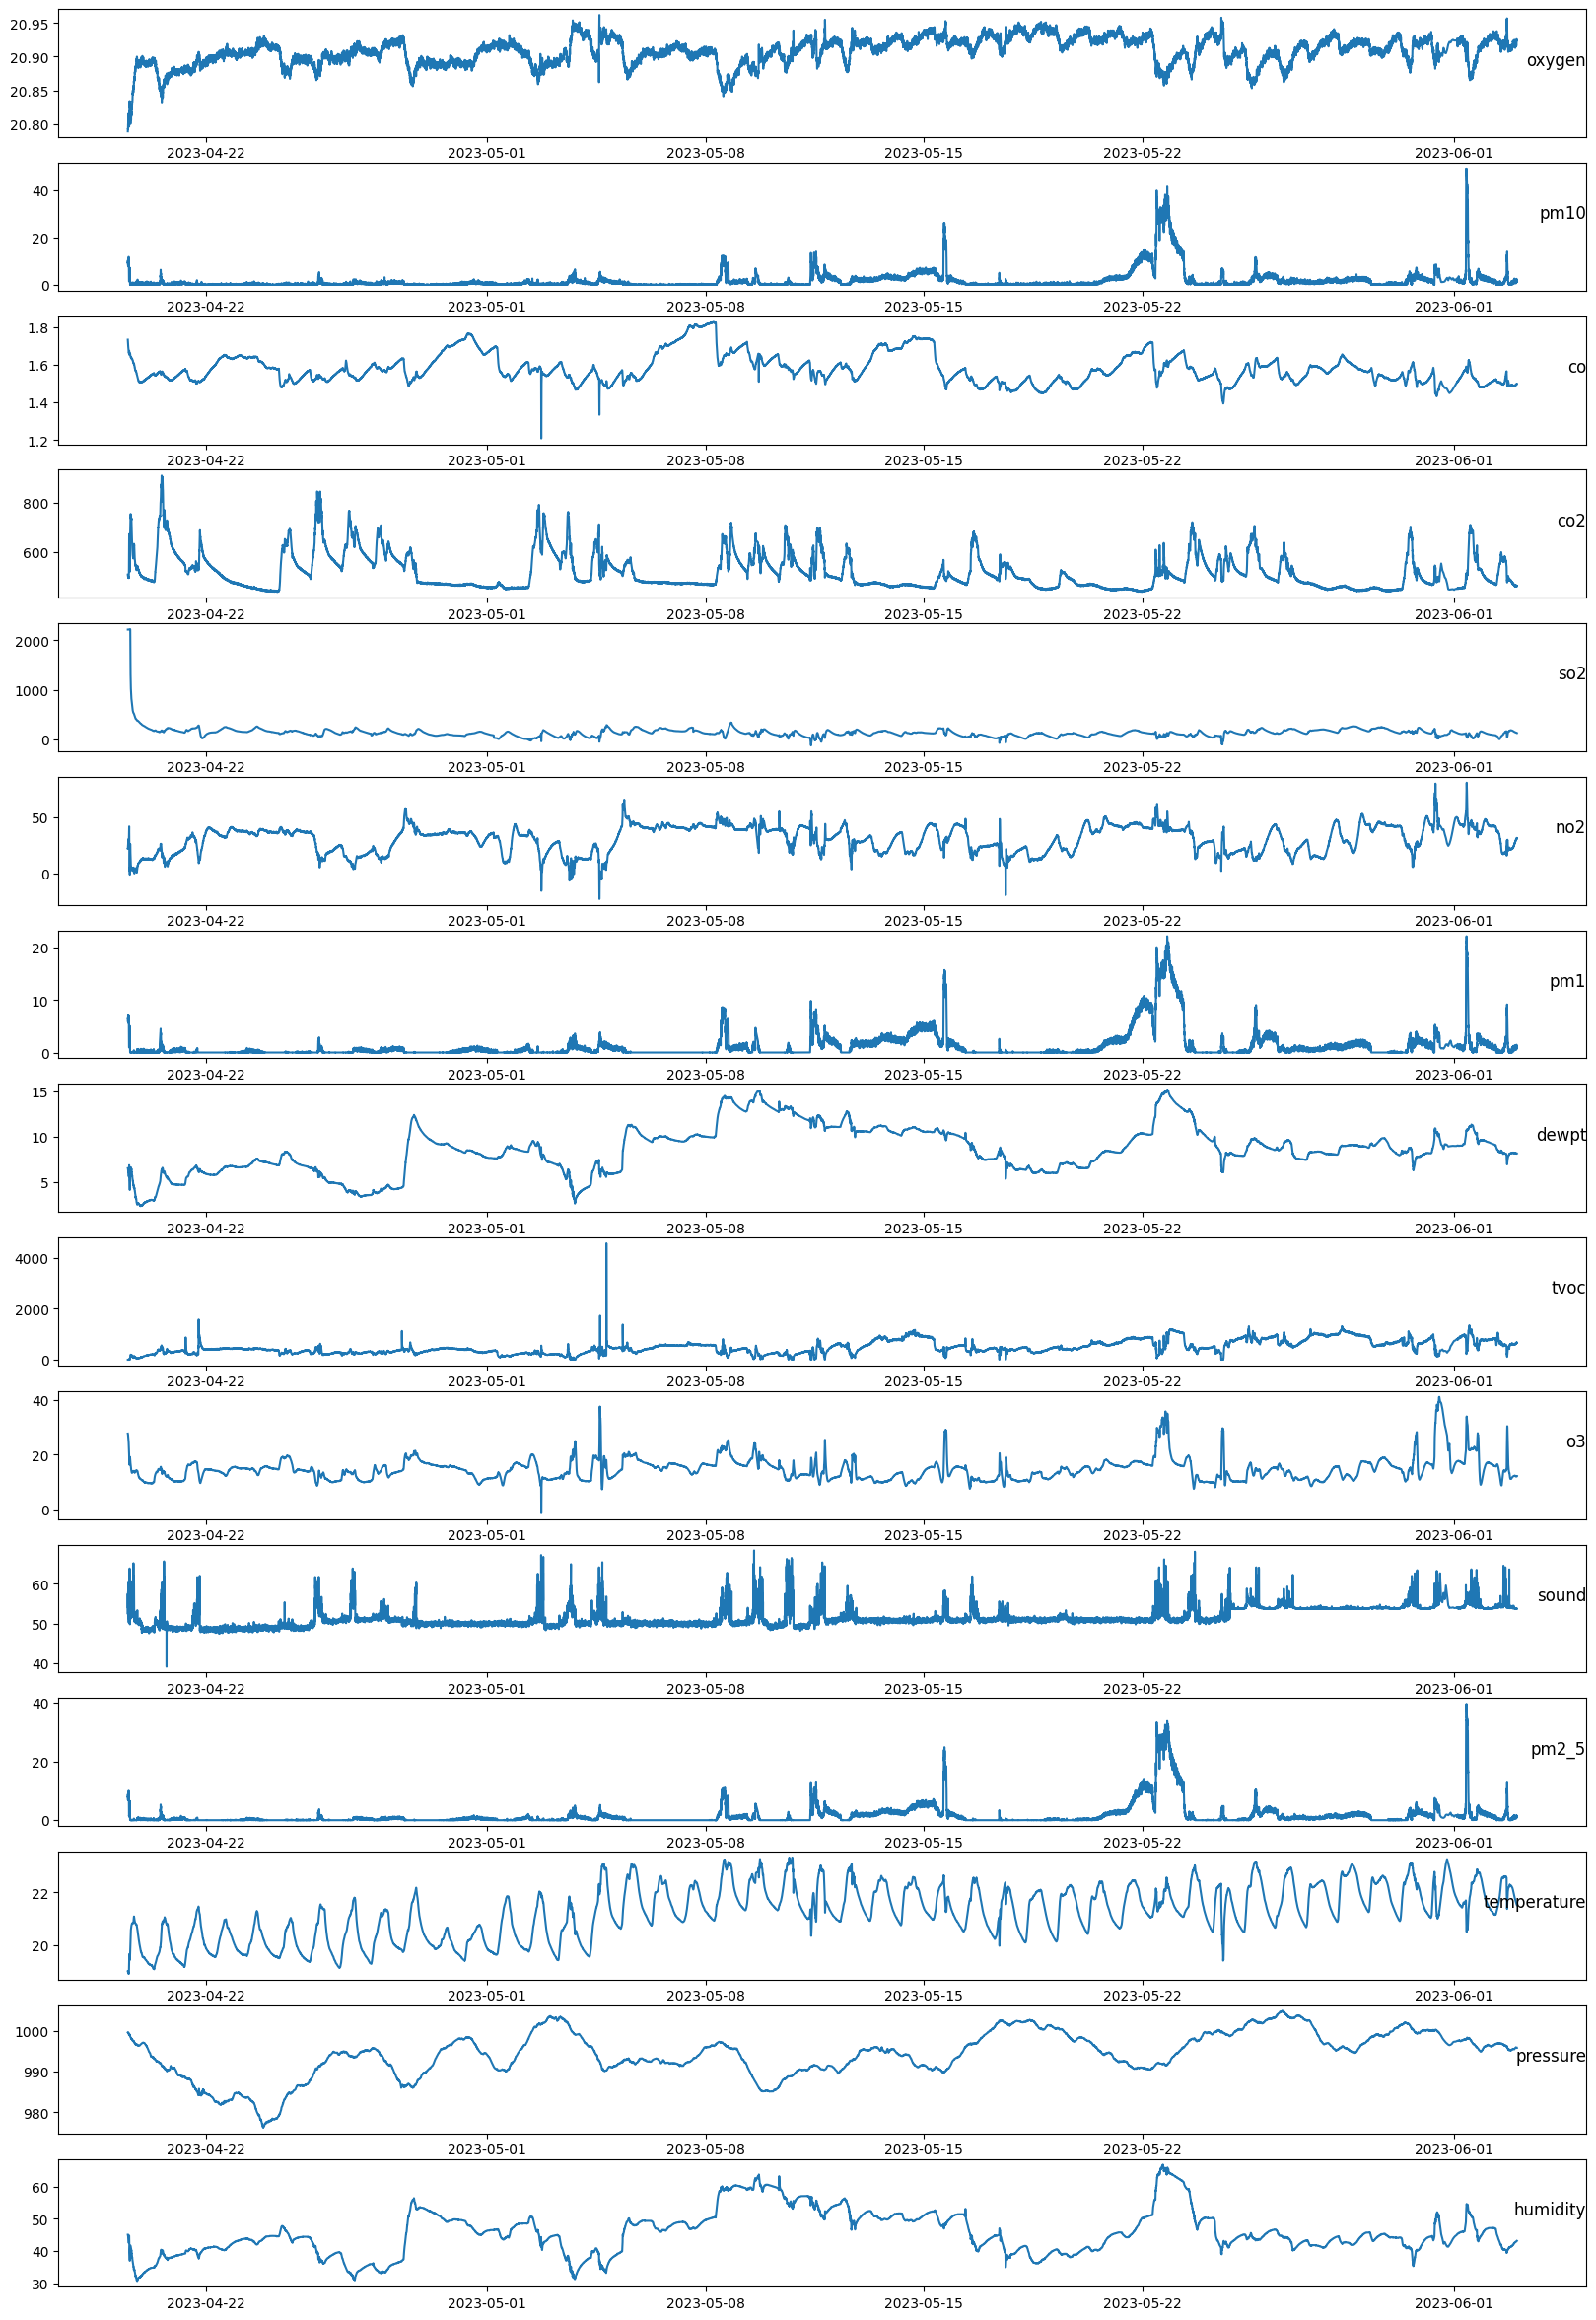

In [40]:
values = data.values
dates = data.index
groups = [0, 1, 2, 3, 4, 5, 6, 7 ,8 ,9 ,10 ,11 ,12, 13, 14]
i = 1

plt.figure(figsize=(20,30))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(dates,values[:, group])
    plt.title(data.columns[group], y=0.5, loc='right')
    i += 1
plt.show()#date

**CNN-LSTM Predictive Modeling**

In [41]:
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from keras.regularizers import l1, l2
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

Les données de la série temporelle sont converties en données d'apprentissage supervisé et des étiquettes sont générées. Les variables d'entrée sont ensuite normalisées. Compte tenu des mesures de la pollution et des conditions météorologiques de l'heure précédente (t-1), nous posons le problème de l'apprentissage supervisé pour prédire la concentration de la pollution à l'heure actuelle (t).

In [42]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    #  (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)] 
    agg = pd.concat(cols, axis=1)
    agg.columns = names


    if dropnan:
        agg.dropna(inplace=True)

    return agg

In [43]:
values = data.values

values = values.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

reframed = series_to_supervised(scaled, 1, 1)
reframed.drop(reframed.columns[[-1,-2,-3]], axis=1, inplace=True)
reframed.head()

var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.000000   0.189904   0.848387   0.149366   0.996458   0.431124   
2   0.005791   0.184298   0.840322   0.141075   0.996445   0.430600   
3   0.000000   0.210760   0.833871   0.139532   0.996406   0.434559   
4   0.023125   0.187009   0.829032   0.139468   0.996424   0.443796   
5   0.017342   0.167540   0.824193   0.140394   0.996436   0.453471   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  ...   var3(t)   var4(t)  \
1   0.290591   0.325957        0.0    0.684472  ...  0.840322  0.141075   
2   0.291717   0.321531        0.0    0.683219  ...  0.833871  0.139532   
3   0.300005   0.320755        0.0    0.681139  ...  0.829032  0.139468   
4   0.304959   0.320910        0.0    0.680407  ...  0.824193  0.140394   
5   0.263208   0.319124        0.0    0.677807  ...  0.817742  0.136453   

    var5(t)   var6(t)   var7(t)   var8(t)  var9(t)  var10(t)  var11(t)  \
1  0.996445  0.430600  0.291717  0.321531      0.0  0.683219  0.452520   
2  0.996406  0.434559  0.300005  0.320755      0.0  0.681139  0.463491   
3  0.996424  0.443796  0.304959  0.320910      0.0  0.680407  0.594671   
4  0.996436  0.453471  0.263208  0.319124      0.0  0.677807  0.628608   
5  0.996360  0.460178  0.288835  0.316950      0.0  0.675136  0.503492   

   var12(t)  
1  0.206875  
2  0.222687  
3  0.206572  
4  0.173711  
5  0.206244  

[5 rows x 27 columns]

In [44]:
n_temps = 1440
n_features = 15

reframed = series_to_supervised(scaled, n_temps, 1)

In [45]:
reframed.drop(reframed.columns[[-1,-2,-3]], axis=1, inplace=True)
reframed.head(10)

var1(t-1440)  var2(t-1440)  var3(t-1440)  var4(t-1440)  var5(t-1440)  \
1440      0.000000      0.189904      0.848387      0.149366      0.996458   
1441      0.005791      0.184298      0.840322      0.141075      0.996445   
1442      0.000000      0.210760      0.833871      0.139532      0.996406   
1443      0.023125      0.187009      0.829032      0.139468      0.996424   
1444      0.017342      0.167540      0.824193      0.140394      0.996436   
1445      0.052032      0.179446      0.817742      0.136453      0.996360   
1446      0.052032      0.165583      0.809677      0.129000      0.996343   
1447      0.063583      0.197468      0.801613      0.128302      0.996262   
1448      0.057808      0.198426      0.795161      0.133763      0.996079   
1449      0.098267      0.184787      0.791935      0.125911      0.996032   

      var6(t-1440)  var7(t-1440)  var8(t-1440)  var9(t-1440)  var10(t-1440)  \
1440      0.431124      0.290591      0.325957           0.0       0.684472   
1441      0.430600      0.291717      0.321531           0.0       0.683219   
1442      0.434559      0.300005      0.320755           0.0       0.681139   
1443      0.443796      0.304959      0.320910           0.0       0.680407   
1444      0.453471      0.263208      0.319124           0.0       0.677807   
1445      0.460178      0.288835      0.316950           0.0       0.675136   
1446      0.468756      0.288925      0.314232           0.0       0.670976   
1447      0.474767      0.309373      0.309341           0.0       0.665280   
1448      0.475073      0.326217      0.304760           0.0       0.660529   
1449      0.475311      0.317209      0.303440           0.0       0.658497   

      ...   var3(t)   var4(t)   var5(t)   var6(t)   var7(t)   var8(t)  \
1440  ...  0.500000  0.200811  0.139095  0.543295  0.000000  0.302586   
1441  ...  0.501613  0.205701  0.139844  0.546806  0.000000  0.303207   
1442  ...  0.501613  0.204943  0.140383  0.549420  0.000000  0.304061   
1443  ...  0.500000  0.204206  0.140742  0.548342  0.000000  0.304527   
1444  ...  0.500000  0.204129  0.140886  0.546090  0.000000  0.306390   
1445  ...  0.501613  0.200637  0.141140  0.544554  0.000000  0.305769   
1446  ...  0.500000  0.201898  0.141533  0.540957  0.000540  0.306623   
1447  ...  0.500000  0.206556  0.141671  0.538448  0.000045  0.307477   
1448  ...  0.501613  0.207845  0.142326  0.537160  0.000000  0.307633   
1449  ...  0.501613  0.211306  0.142816  0.538467  0.000000  0.307555   

       var9(t)  var10(t)  var11(t)  var12(t)  
1440  0.046314  0.420208  0.328529  0.000000  
1441  0.046773  0.420161  0.334833  0.000000  
1442  0.047219  0.418601  0.333231  0.000000  
1443  0.047363  0.417845  0.337047  0.000000  
1444  0.047463  0.417230  0.345940  0.000000  
1445  0.049822  0.418364  0.336911  0.000000  
1446  0.047779  0.418695  0.323963  0.000303  
1447  0.047324  0.420468  0.328188  0.000025  
1448  0.046930  0.421957  0.314150  0.000000  
1449  0.047382  0.422406  0.332039  0.000000  

[10 rows x 21612 columns]

In [46]:
values = reframed.values
num_rows = data.shape[0]
train_samples = int(num_rows * 0.9)

train = values[:train_samples, :]
test = values[train_samples:, :]
n_obs = n_temps * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features+3:]
test_X, test_y = test[:, :n_obs], test[:, -n_features+3:]
print( train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(28321, 21600) (28321, 12) (1707, 21600) (1707, 12)


In [47]:
train_X = train_X.reshape((train_X.shape[0], n_temps, n_features))
test_X = test_X.reshape((test_X.shape[0], n_temps, n_features))

print(test_X.shape,train_X.shape)

(1707, 1440, 15) (28321, 1440, 15)


In [48]:
def train_and_evaluate(filters, kernel_size, units, dropout_rate, learning_rate):
    filters = int(filters)
    kernel_size = int(kernel_size)
    units = int(units)

    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(dropout_rate))

    model.add(LSTM(units, activation='relu'))

    model.add(Dense(train_y.shape[1]))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='mae', optimizer=optimizer)
    model.fit(train_X, train_y, epochs=50, batch_size=128, validation_data=(test_X, test_y), verbose=0, shuffle=False)

    yhat = model.predict(test_X)

    selected_columns = [12, 13, 14]
    test_X_reshaped = test_X[:, -1, :]

    inv_yhat = np.concatenate((yhat, test_X_reshaped[:, selected_columns]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)

    test_y_reshaped = test_y.reshape((len(test_y), test_y.shape[1]))
    inv_y = np.concatenate((test_y_reshaped, test_X_reshaped[:, selected_columns]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)

    rmse = sqrt(mean_squared_error(inv_y[:, 0], inv_yhat[:, 0]))
    return -rmse

pbounds = {
    'filters': (32, 128),
    'kernel_size': (2, 5),
    'units': (50, 200),
    'dropout_rate': (0.1, 0.5),
    'learning_rate': (0.0001, 0.01)
}

optimizer = BayesianOptimization(
    f=train_and_evaluate,
    pbounds=pbounds,
    random_state=42
)

optimizer.maximize(init_points=2, n_iter=10)
print(optimizer.max)

|   iter    |  target   | dropou... |  filters  | kernel... | learni... |   units   |
-------------------------------------------------------------------------------------


d:\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step


ValueError: Input contains NaN.

In [ ]:
danger_limits = {
    'pm10': 101,
    'co': 201,
    'co2': 1001,
    'so2': 81,
    'no2': 81,
    'tvoc': 500,
    'o3': 100,
    'pm2_5': 61,
}

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

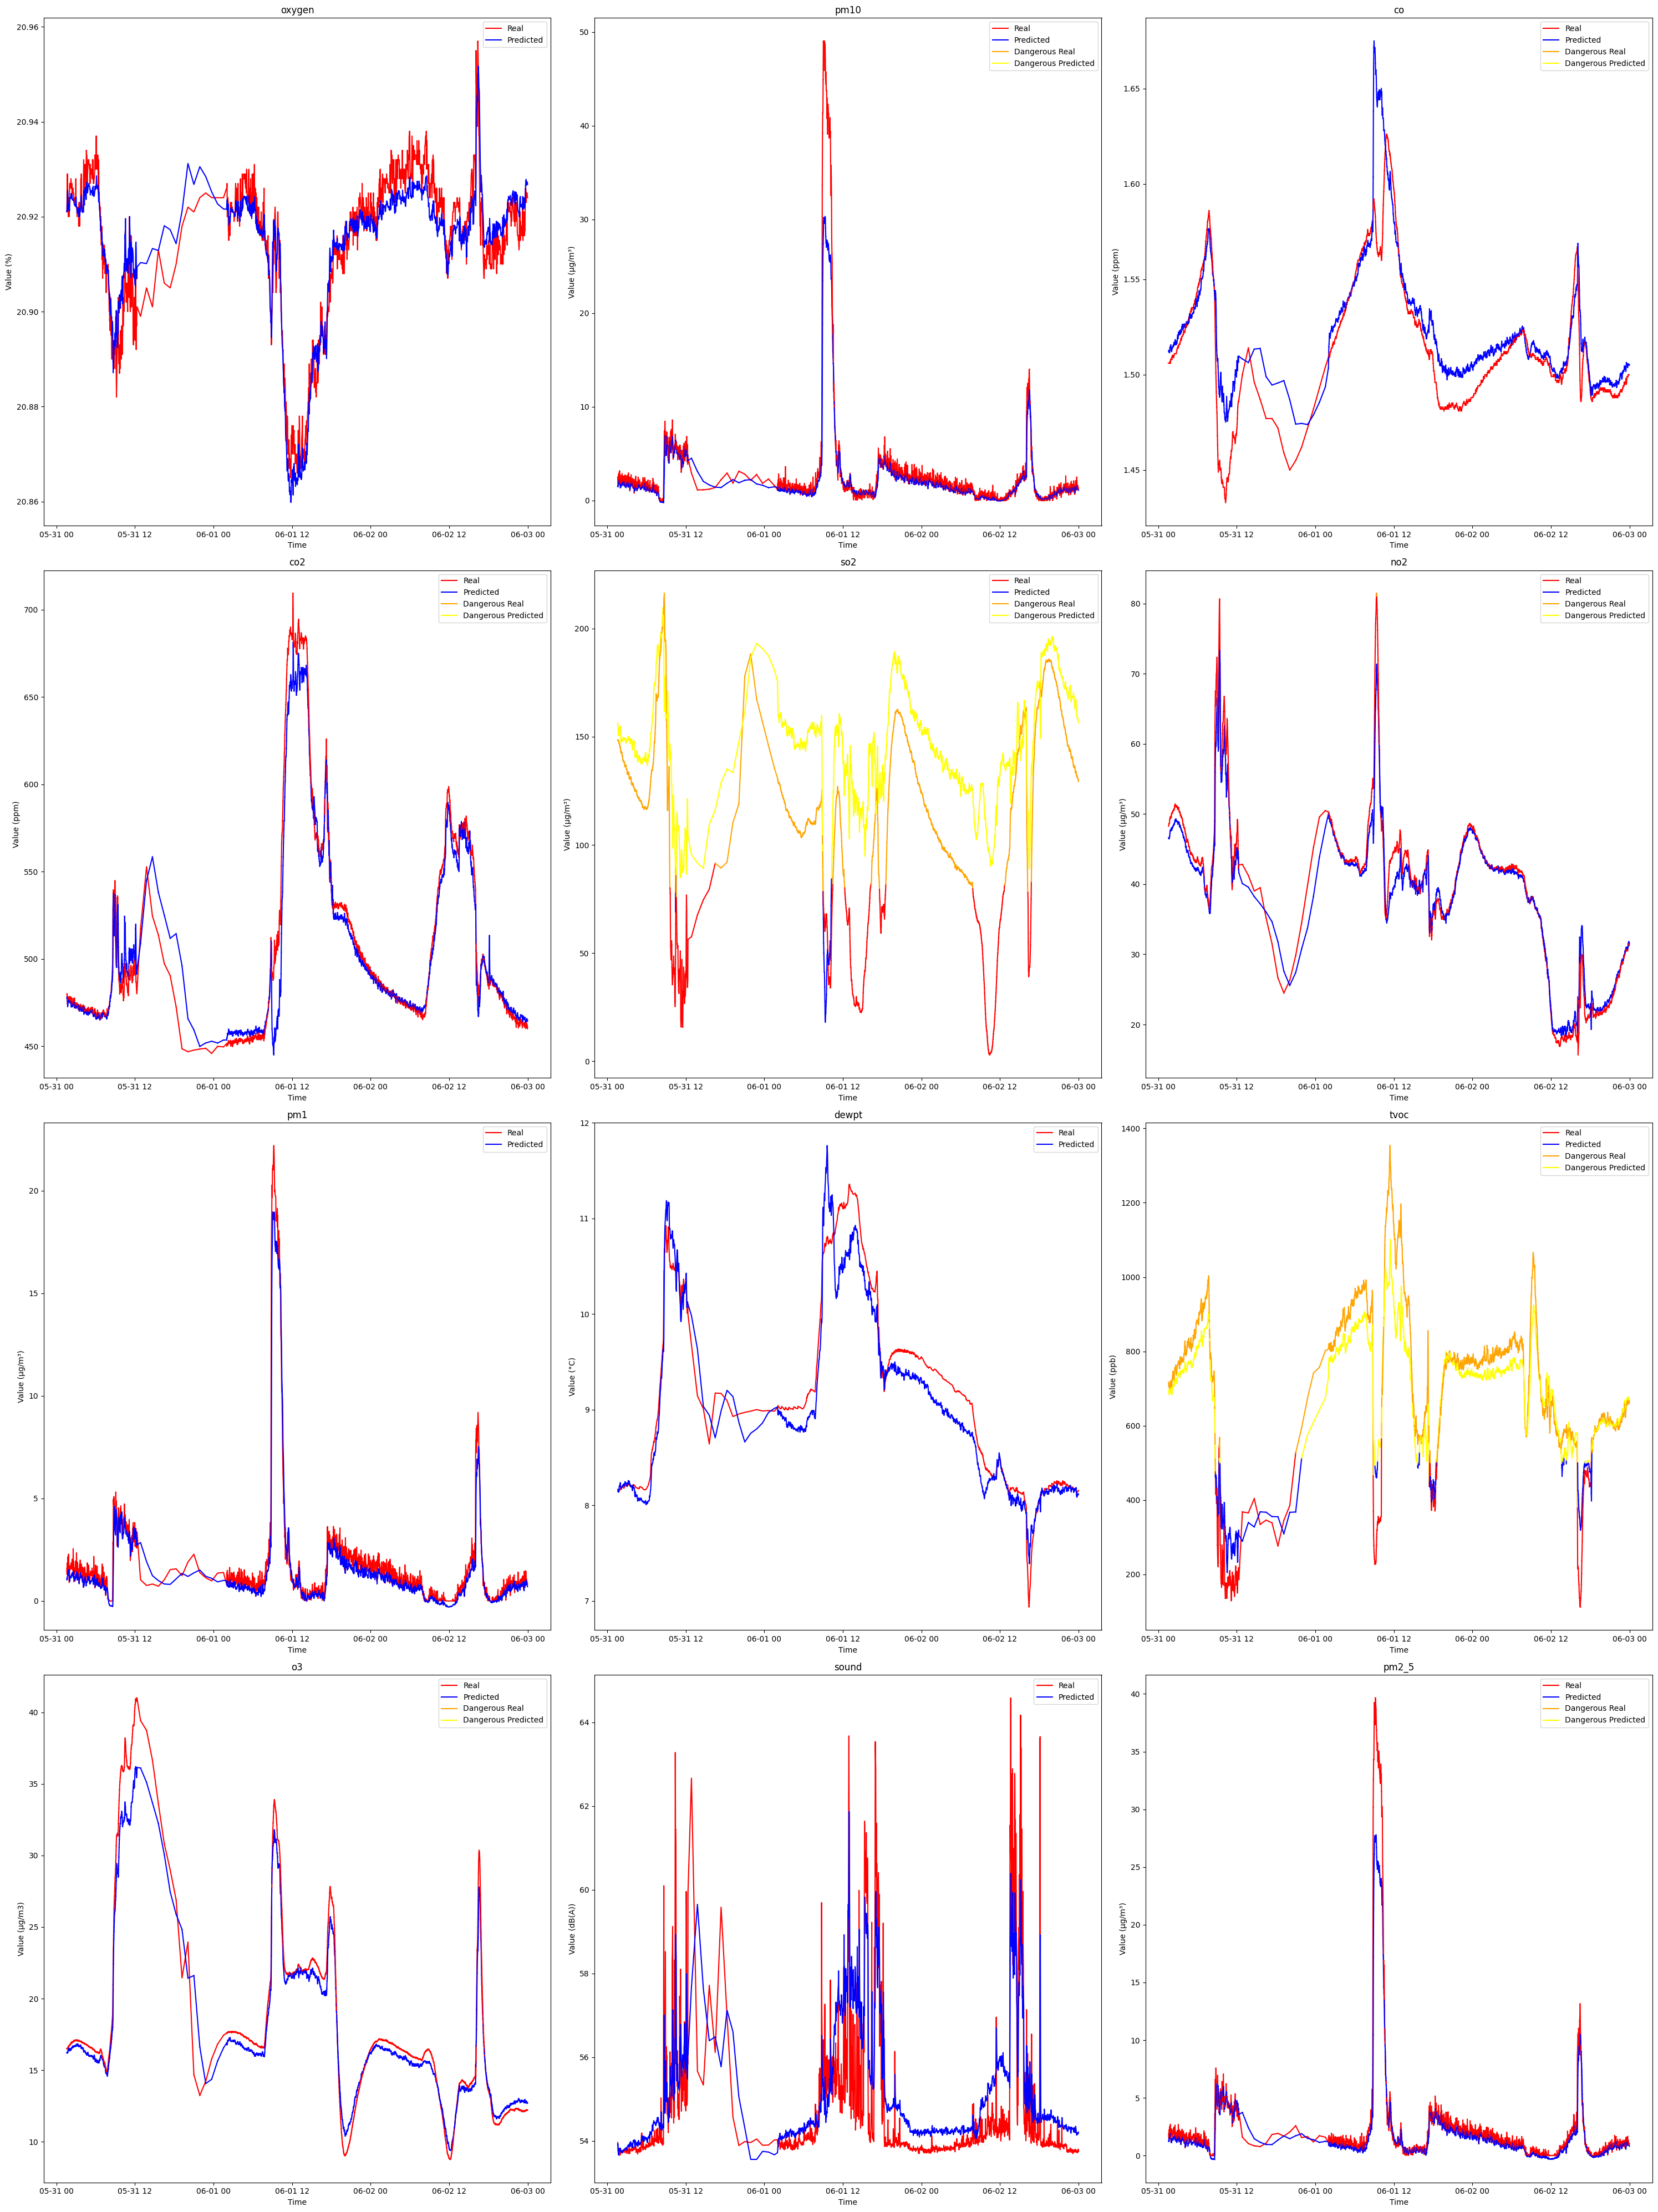

In [ ]:
dates = dates[-test_y.shape[0]:]
fig, axs = plt.subplots(4, 3, figsize=(30, 40))
feature_indices = {
    'oxygen': 0, 'pm10': 1, 'co': 2, 'co2': 3, 'so2': 4,
    'no2': 5, 'pm1': 6, 'dewpt': 7, 'tvoc': 8, 'o3' : 9, 'sound': 10, 'pm2_5': 11
}

feature_units = {
    'oxygen': '%', 'pm10': 'µg/m³', 'co': 'ppm', 'co2': 'ppm',
    'so2': 'µg/m³', 'no2': 'µg/m³', 'pm1': 'µg/m³',
    'dewpt': '°C', 'tvoc': 'ppb', 'o3': 'µg/m3', 'sound': 'dB(A)', 'pm2_5': 'µg/m³'
}

for i, (feature, index) in enumerate(feature_indices.items()):
    row = i // 3
    col = i % 3

    real_values = inv_y[:, index]
    predicted_values = inv_yhat[:, index]

    axs[row, col].set_title(feature)
    axs[row, col].set_xlabel('Time')
    axs[row, col].set_ylabel(f'Value ({feature_units[feature]})')

    if feature in danger_limits:
        if isinstance(danger_limits[feature], tuple):
            lower, upper = danger_limits[feature]
            real_colors = ['orange' if (x < lower or x > upper) else 'red' for x in real_values]
            pred_colors = ['yellow' if (x < lower or x > upper) else 'blue' for x in predicted_values]
        else:
            limit = danger_limits[feature]
            real_colors = ['orange' if x > limit else 'red' for x in real_values]
            pred_colors = ['yellow' if x > limit else 'blue' for x in predicted_values]

        for j in range(len(dates) - 1):
            axs[row, col].plot(dates[j:j+2], real_values[j:j+2], color=real_colors[j])
            axs[row, col].plot(dates[j:j+2], predicted_values[j:j+2], color=pred_colors[j])
    else:
        axs[row, col].plot(dates, real_values, color='red', label='Real')
        axs[row, col].plot(dates, predicted_values, color='blue', label='Predicted')

    axs[row, col].legend()

for ax in axs.flat:
    handles, labels = ax.get_legend_handles_labels()
    if not labels:
        ax.plot([], [], color='red', label='Real')
        ax.plot([], [], color='blue', label='Predicted')
        ax.plot([], [], color='orange', label='Dangerous Real')
        ax.plot([], [], color='yellow', label='Dangerous Predicted')
    ax.legend()

plt.tight_layout()
plt.show()
# for i, (feature, index) in enumerate(feature_indices.items()):
#     row = i // 3
#     col = i % 3

#     axs[row, col].plot(dates,inv_y[:, index], color='red', label='Real')
#     axs[row, col].plot(dates,inv_yhat[:, index], color='blue', label='Predicted')
#     axs[row, col].set_title(feature)
#     axs[row, col].set_xlabel('Time')
#     axs[row, col].set_ylabel(f'Value ({feature_units[feature]})')
#     axs[row, col].legend()

# plt.tight_layout()
# plt.show()

In [ ]:
selected_columns2 = [i for i in range(n_features) if i not in [12, 13, 14]]
inv_yhat = inv_yhat[:, selected_columns2]
inv_y = inv_y[:, selected_columns2]
print(inv_y.shape, inv_yhat.shape)
feature_names = ['oxygen', 'pm10', 'co', 'co2', 'so2', 'no2', 'pm1', 'dewpt', 'tvoc', 'o3', 'sound', 'pm2_5']

for i, feature in enumerate(feature_names):
    rmse = sqrt(mean_squared_error(inv_y[:, i], inv_yhat[:, i]))
    print(f'Test RMSE for {feature}: {rmse:.3f}')

(1707, 12) (1707, 12)
Test RMSE for oxygen: 0.005
Test RMSE for pm10: 2.621
Test RMSE for co: 0.019
Test RMSE for co2: 11.714
Test RMSE for so2: 43.574
Test RMSE for no2: 2.197
Test RMSE for pm1: 0.691
Test RMSE for dewpt: 0.263
Test RMSE for tvoc: 84.933
Test RMSE for o3: 1.230
Test RMSE for sound: 1.110
Test RMSE for pm2_5: 1.812


In [ ]:
# iaqi_condition_withouto3 = lambda x: (x[:, 6] <= 10) & (x[:, 11] <= 25) & (x[:, 1] <= 50) & (x[:, 3] < 800) & (x[:, 8] < 300)
# iaqi_condition = lambda x: (x[:, 6] <= 10) & (x[:, 10] <= 25) & (x[:, 1] <= 50) & (x[:, 3] < 800) & (x[:, 8] < 300) & (x[:, 9] < 18)
# inv_y_iaq = iaqi_condition_withouto3(inv_y).astype(int)
# inv_yhat_iaq = iaqi_condition_withouto3(inv_yhat).astype(int)
# inv_y_iaq2 = iaqi_condition(inv_y).astype(int)
# inv_yhat_iaq2 = iaqi_condition(inv_yhat).astype(int)

# inv_y = np.hstack((inv_y, inv_y_iaq.reshape(-1, 1)))
# inv_yhat = np.hstack((inv_yhat, inv_yhat_iaq.reshape(-1, 1)))
# inv_y2 = np.hstack((inv_y, inv_y_iaq2.reshape(-1, 1)))
# inv_yhat2 = np.hstack((inv_yhat, inv_yhat_iaq2.reshape(-1, 1)))

In [ ]:
## PM2.5 Sub-Index calculation
def get_PM25_subindex(x):
    if x <= 30:
        return x * 50 / 30
    elif x <= 60:
        return 50 + (x - 30) * 50 / 30
    elif x <= 90:
        return 100 + (x - 60) * 100 / 30
    elif x <= 120:
        return 200 + (x - 90) * 100 / 30
    elif x <= 250:
        return 300 + (x - 120) * 100 / 130
    elif x > 250:
        return 400 + (x - 250) * 100 / 130
    else:
        return 0

inv_yhat_PM25_values = inv_yhat[:, 11]
inv_y_PM25_values = inv_y[:, 11]

inv_yhat_PM25 = np.array([get_PM25_subindex(x) for x in inv_yhat_PM25_values]).astype(float)
inv_y_PM25 = np.array([get_PM25_subindex(x) for x in inv_y_PM25_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_PM25.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_PM25.reshape(-1, 1)))

In [ ]:
## PM10 Sub-Index calculation
def get_PM10_subindex(x):
    if x <= 50:
        return x
    elif x <= 100:
        return x
    elif x <= 250:
        return 100 + (x - 100) * 100 / 150
    elif x <= 350:
        return 200 + (x - 250)
    elif x <= 430:
        return 300 + (x - 350) * 100 / 80
    elif x > 430:
        return 400 + (x - 430) * 100 / 80
    else:
        return 0

inv_yhat_PM10_values = inv_yhat[:, 1]
inv_y_PM10_values = inv_y[:, 1]

inv_yhat_PM10 = np.array([get_PM10_subindex(x) for x in inv_yhat_PM10_values]).astype(float)
inv_y_PM10 = np.array([get_PM10_subindex(x) for x in inv_y_PM10_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_PM10.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_PM10.reshape(-1, 1)))

In [ ]:
## SO2 Sub-Index calculation
def get_SO2_subindex(x):
    if x <= 40:
        return x * 50 / 40
    elif x <= 80:
        return 50 + (x - 40) * 50 / 40
    elif x <= 380:
        return 100 + (x - 80) * 100 / 300
    elif x <= 800:
        return 200 + (x - 380) * 100 / 420
    elif x <= 1600:
        return 300 + (x - 800) * 100 / 800
    elif x > 1600:
        return 400 + (x - 1600) * 100 / 800
    else:
        return 0

inv_yhat_SO2_values = inv_yhat[:, 4]
inv_y_SO2_values = inv_y[:, 4]

inv_yhat_SO2= np.array([get_SO2_subindex(x) for x in inv_yhat_SO2_values]).astype(float)
inv_y_SO2 = np.array([get_SO2_subindex(x) for x in inv_y_SO2_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_SO2.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_SO2.reshape(-1, 1)))

In [ ]:
## NO2 Sub-Index calculation
def get_NO2_subindex(x):
    if x <= 40:
        return x * 50 / 40
    elif x <= 80:
        return 50 + (x - 40) * 50 / 40
    elif x <= 180:
        return 100 + (x - 80) * 100 / 100
    elif x <= 280:
        return 200 + (x - 180) * 100 / 100
    elif x <= 400:
        return 300 + (x - 280) * 100 / 120
    elif x > 400:
        return 400 + (x - 400) * 100 / 120
    else:
        return 0

inv_yhat_NO2_values = inv_yhat[:, 5]
inv_y_NO2_values = inv_y[:, 5]

inv_yhat_NO2= np.array([get_NO2_subindex(x) for x in inv_yhat_NO2_values]).astype(float)
inv_y_NO2 = np.array([get_NO2_subindex(x) for x in inv_y_NO2_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_NO2.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_NO2.reshape(-1, 1)))

In [ ]:
## CO Sub-Index calculation
def get_CO_subindex(x):
    if x <= 1:
        return x * 50 / 1
    elif x <= 2:
        return 50 + (x - 1) * 50 / 1
    elif x <= 10:
        return 100 + (x - 2) * 100 / 8
    elif x <= 17:
        return 200 + (x - 10) * 100 / 7
    elif x <= 34:
        return 300 + (x - 17) * 100 / 17
    elif x > 34:
        return 400 + (x - 34) * 100 / 17
    else:
        return 0

inv_yhat_CO_values = inv_yhat[:, 2]
inv_y_CO_values = inv_y[:, 2]

inv_yhat_CO= np.array([get_CO_subindex(x) for x in inv_yhat_CO_values]).astype(float)
inv_y_CO = np.array([get_CO_subindex(x) for x in inv_y_CO_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_CO.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_CO.reshape(-1, 1)))

In [ ]:
## O3 Sub-Index calculation
def get_O3_subindex(x):
    if x <= 50:
        return x * 50 / 50
    elif x <= 100:
        return 50 + (x - 50) * 50 / 50
    elif x <= 168:
        return 100 + (x - 100) * 100 / 68
    elif x <= 208:
        return 200 + (x - 168) * 100 / 40
    elif x <= 748:
        return 300 + (x - 208) * 100 / 539
    elif x > 748:
        return 400 + (x - 400) * 100 / 539
    else:
        return 0

inv_yhat_O3_values = inv_yhat[:, 9]
inv_y_O3_values = inv_y[:, 9]

inv_yhat_O3= np.array([get_O3_subindex(x) for x in inv_yhat_O3_values]).astype(float)
inv_y_O3 = np.array([get_O3_subindex(x) for x in inv_y_O3_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_O3.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_O3.reshape(-1, 1)))

In [ ]:
## AQI bucketing
def get_AQI_bucket(x):
    if x <= 50:
        return "Good"
    elif x <= 100:
        return "Satisfactory"
    elif x <= 200:
        return "Moderate"
    elif x <= 300:
        return "Poor"
    elif x <= 400:
        return "Very Poor"
    elif x > 400:
        return "Severe"
    else:
        return np.NaN

PM25_SubIndex_col = 12
PM10_SubIndex_col = 13
SO2_SubIndex_col = 14
NO2_SubIndex_col = 15
CO_SubIndex_col = 16
O3_SubIndex_col = 17

inv_yhat_Checks = ((inv_yhat[:, PM25_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, PM10_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, SO2_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, NO2_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, CO_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, O3_SubIndex_col] > 0).astype(int))

inv_y_Checks = ((inv_y[:, PM25_SubIndex_col] > 0).astype(int) +
                (inv_y[:, PM10_SubIndex_col] > 0).astype(int) +
                (inv_y[:, SO2_SubIndex_col] > 0).astype(int) +
                (inv_y[:, NO2_SubIndex_col] > 0).astype(int) +
                (inv_y[:, CO_SubIndex_col] > 0).astype(int) +
                (inv_y[:, O3_SubIndex_col] > 0).astype(int))


inv_yhat_AQI_calculated = np.max(inv_yhat[:, [PM25_SubIndex_col, PM10_SubIndex_col, SO2_SubIndex_col, NO2_SubIndex_col, CO_SubIndex_col, O3_SubIndex_col]], axis=1)
inv_y_AQI_calculated = np.max(inv_y[:, [PM25_SubIndex_col, PM10_SubIndex_col, SO2_SubIndex_col, NO2_SubIndex_col, CO_SubIndex_col, O3_SubIndex_col]], axis=1)

inv_yhat_AQI_calculated[(inv_yhat[:, PM25_SubIndex_col] + inv_yhat[:, PM10_SubIndex_col] <= 0) | (inv_yhat_Checks < 3)] = np.NaN
inv_y_AQI_calculated[(inv_y[:, PM25_SubIndex_col] + inv_y[:, PM10_SubIndex_col] <= 0) | (inv_y_Checks < 3)] = np.NaN

inv_yhat_AQI_bucket_calculated = np.array([get_AQI_bucket(x) for x in inv_yhat_AQI_calculated])
inv_y_AQI_bucket_calculated = np.array([get_AQI_bucket(x) for x in inv_y_AQI_calculated])

inv_yhat = np.hstack((inv_yhat, inv_yhat_AQI_calculated.reshape(-1, 1), inv_yhat_Checks.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_AQI_calculated.reshape(-1, 1), inv_y_Checks.reshape(-1, 1)))

inv_yhat_df = pd.DataFrame(inv_yhat, columns=[f'col{i}' for i in range(inv_yhat.shape[1] - 2)] + ['AQI_calculated', 'Checks'])
inv_y_df = pd.DataFrame(inv_y, columns=[f'col{i}' for i in range(inv_y.shape[1] - 2)] + ['AQI_calculated', 'Checks'])

inv_yhat_df['AQI_bucket_calculated'] = inv_yhat_AQI_bucket_calculated
inv_y_df['AQI_bucket_calculated'] = inv_y_AQI_bucket_calculated

print(inv_yhat_df.head(5))
print(inv_y_df.head(5))

        col0      col1      col2        col3        col4       col5      col6  \
0  20.921265  1.493375  1.512033  477.499817  156.400589  46.619621  1.032668   
1  20.921013  1.649490  1.512747  478.429901  155.306107  46.484951  1.136078   
2  20.921726  1.511824  1.511949  477.986023  153.648102  46.578331  1.039582   
3  20.924435  1.762650  1.512048  475.747925  150.841019  46.495529  1.219071   
4  20.925531  1.763410  1.511549  472.778259  150.587357  46.748821  1.228985   

       col7        col8       col9  ...     col11     col12     col13  \
0  8.166713  696.690186  16.200798  ...  1.225794  2.042989  1.493375   
1  8.160973  693.790833  16.234962  ...  1.367574  2.279291  1.649490   
2  8.158614  686.812866  16.255768  ...  1.240875  2.068125  1.511824   
3  8.138090  683.450317  16.204800  ...  1.475394  2.458989  1.762650   
4  8.136929  687.803284  16.225418  ...  1.479293  2.465489  1.763410   

        col14      col15      col16      col17  AQI_calculated  Checks  \


In [ ]:

from sklearn.metrics import accuracy_score
accuracy_normalized = accuracy_score(inv_y[:,-1], inv_yhat[:,-1], normalize=True)
print("Accuracy: " + str(accuracy_normalized))

Accuracy: 0.9226713532513181


In [ ]:
num_correct = accuracy_score(inv_y[:,-1], inv_yhat[:,-1], normalize=False)
print(num_correct) 

1575.0


**Multivariate RNN Predictive Modeling**

In [ ]:
values = data.values

values = values.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

reframed = series_to_supervised(scaled, 1, 1)
reframed.drop(reframed.columns[[-1,-2,-3]], axis=1, inplace=True)
reframed.head()

var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.000000   0.189904   0.848387   0.149366   0.996458   0.431124   
2   0.005791   0.184298   0.840322   0.141075   0.996445   0.430600   
3   0.000000   0.210760   0.833871   0.139532   0.996406   0.434559   
4   0.023125   0.187009   0.829032   0.139468   0.996424   0.443796   
5   0.017342   0.167540   0.824193   0.140394   0.996436   0.453471   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  ...   var3(t)   var4(t)  \
1   0.290591   0.325957        0.0    0.684472  ...  0.840322  0.141075   
2   0.291717   0.321531        0.0    0.683219  ...  0.833871  0.139532   
3   0.300005   0.320755        0.0    0.681139  ...  0.829032  0.139468   
4   0.304959   0.320910        0.0    0.680407  ...  0.824193  0.140394   
5   0.263208   0.319124        0.0    0.677807  ...  0.817742  0.136453   

    var5(t)   var6(t)   var7(t)   var8(t)  var9(t)  var10(t)  var11(t)  \
1  0.996445  0.430600  0.291717  0.321531      0.0  0.683219  0.452520   
2  0.996406  0.434559  0.300005  0.320755      0.0  0.681139  0.463491   
3  0.996424  0.443796  0.304959  0.320910      0.0  0.680407  0.594671   
4  0.996436  0.453471  0.263208  0.319124      0.0  0.677807  0.628608   
5  0.996360  0.460178  0.288835  0.316950      0.0  0.675136  0.503492   

   var12(t)  
1  0.206875  
2  0.222687  
3  0.206572  
4  0.173711  
5  0.206244  

[5 rows x 27 columns]

In [ ]:
n_temps = 1440
n_features = 15

reframed = series_to_supervised(scaled, n_temps, 1)

In [ ]:
reframed.drop(reframed.columns[[-1,-2,-3]], axis=1, inplace=True)
reframed.head(10)

var1(t-1440)  var2(t-1440)  var3(t-1440)  var4(t-1440)  var5(t-1440)  \
1440      0.000000      0.189904      0.848387      0.149366      0.996458   
1441      0.005791      0.184298      0.840322      0.141075      0.996445   
1442      0.000000      0.210760      0.833871      0.139532      0.996406   
1443      0.023125      0.187009      0.829032      0.139468      0.996424   
1444      0.017342      0.167540      0.824193      0.140394      0.996436   
1445      0.052032      0.179446      0.817742      0.136453      0.996360   
1446      0.052032      0.165583      0.809677      0.129000      0.996343   
1447      0.063583      0.197468      0.801613      0.128302      0.996262   
1448      0.057808      0.198426      0.795161      0.133763      0.996079   
1449      0.098267      0.184787      0.791935      0.125911      0.996032   

      var6(t-1440)  var7(t-1440)  var8(t-1440)  var9(t-1440)  var10(t-1440)  \
1440      0.431124      0.290591      0.325957           0.0       0.684472   
1441      0.430600      0.291717      0.321531           0.0       0.683219   
1442      0.434559      0.300005      0.320755           0.0       0.681139   
1443      0.443796      0.304959      0.320910           0.0       0.680407   
1444      0.453471      0.263208      0.319124           0.0       0.677807   
1445      0.460178      0.288835      0.316950           0.0       0.675136   
1446      0.468756      0.288925      0.314232           0.0       0.670976   
1447      0.474767      0.309373      0.309341           0.0       0.665280   
1448      0.475073      0.326217      0.304760           0.0       0.660529   
1449      0.475311      0.317209      0.303440           0.0       0.658497   

      ...   var3(t)   var4(t)   var5(t)   var6(t)   var7(t)   var8(t)  \
1440  ...  0.500000  0.200811  0.139095  0.543295  0.000000  0.302586   
1441  ...  0.501613  0.205701  0.139844  0.546806  0.000000  0.303207   
1442  ...  0.501613  0.204943  0.140383  0.549420  0.000000  0.304061   
1443  ...  0.500000  0.204206  0.140742  0.548342  0.000000  0.304527   
1444  ...  0.500000  0.204129  0.140886  0.546090  0.000000  0.306390   
1445  ...  0.501613  0.200637  0.141140  0.544554  0.000000  0.305769   
1446  ...  0.500000  0.201898  0.141533  0.540957  0.000540  0.306623   
1447  ...  0.500000  0.206556  0.141671  0.538448  0.000045  0.307477   
1448  ...  0.501613  0.207845  0.142326  0.537160  0.000000  0.307633   
1449  ...  0.501613  0.211306  0.142816  0.538467  0.000000  0.307555   

       var9(t)  var10(t)  var11(t)  var12(t)  
1440  0.046314  0.420208  0.328529  0.000000  
1441  0.046773  0.420161  0.334833  0.000000  
1442  0.047219  0.418601  0.333231  0.000000  
1443  0.047363  0.417845  0.337047  0.000000  
1444  0.047463  0.417230  0.345940  0.000000  
1445  0.049822  0.418364  0.336911  0.000000  
1446  0.047779  0.418695  0.323963  0.000303  
1447  0.047324  0.420468  0.328188  0.000025  
1448  0.046930  0.421957  0.314150  0.000000  
1449  0.047382  0.422406  0.332039  0.000000  

[10 rows x 21612 columns]

In [ ]:
values = reframed.values
num_rows = data.shape[0]
train_samples = int(num_rows * 0.9)

train = values[:train_samples, :]
test = values[train_samples:, :]
n_obs = n_temps * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features+3:]
test_X, test_y = test[:, :n_obs], test[:, -n_features+3:]
print( train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(28321, 21600) (28321, 12) (1707, 21600) (1707, 12)


In [ ]:
train_X = train_X.reshape((train_X.shape[0], n_temps, n_features))
test_X = test_X.reshape((test_X.shape[0], n_temps, n_features))

print(test_X.shape,train_X.shape)

(1707, 1440, 15) (28321, 1440, 15)


In [ ]:
model = Sequential()
model.add(SimpleRNN(units = 50, activation='tanh', input_shape= (train_X.shape[1],train_X.shape[2])))
model.add(Dropout(0.3))
model.add(Dense(units = 12))
model.compile(loss='mae', optimizer='adam')
print(model.summary())

d:\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 50)             │         3,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │           612 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,912 (15.28 KB)

 Trainable params: 3,912 (15.28 KB)

 Non-trainable params: 0 (0.00 B)

None


Epoch 1/100
222/222 - 38s - 172ms/step - loss: 0.1504 - val_loss: 0.0629
Epoch 2/100
222/222 - 43s - 192ms/step - loss: 0.0785 - val_loss: 0.0392
Epoch 3/100
222/222 - 39s - 174ms/step - loss: 0.0593 - val_loss: 0.0366
Epoch 4/100
222/222 - 42s - 187ms/step - loss: 0.0481 - val_loss: 0.0268
Epoch 5/100
222/222 - 51s - 229ms/step - loss: 0.0411 - val_loss: 0.0271
Epoch 6/100
222/222 - 39s - 177ms/step - loss: 0.0372 - val_loss: 0.0248
Epoch 7/100
222/222 - 51s - 228ms/step - loss: 0.0342 - val_loss: 0.0225
Epoch 8/100
222/222 - 52s - 235ms/step - loss: 0.0316 - val_loss: 0.0227
Epoch 9/100
222/222 - 39s - 176ms/step - loss: 0.0306 - val_loss: 0.0214
Epoch 10/100
222/222 - 50s - 223ms/step - loss: 0.0295 - val_loss: 0.0213
Epoch 11/100
222/222 - 52s - 234ms/step - loss: 0.0288 - val_loss: 0.0222
Epoch 12/100
222/222 - 41s - 186ms/step - loss: 0.0289 - val_loss: 0.0231
Epoch 13/100
222/222 - 49s - 222ms/step - loss: 0.0282 - val_loss: 0.0223
Epoch 14/100
222/222 - 38s - 171ms/step - loss:

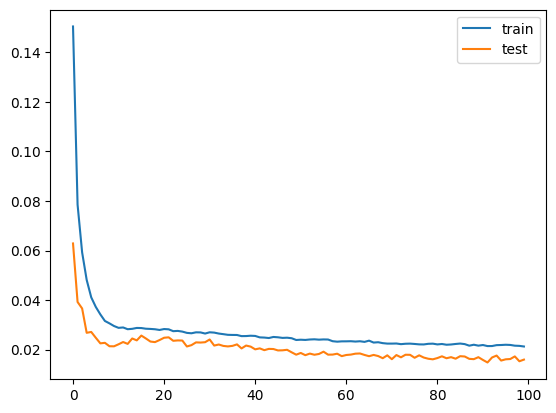

In [ ]:
# early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
# history = model.fit(train_X, train_y, epochs=100, batch_size=128, validation_data=(test_X, test_y), verbose=2, shuffle=False, callbacks=[early_stopping])
history = model.fit(train_X, train_y, epochs=100, batch_size=128, validation_data=(test_X, test_y), verbose=2, shuffle=False)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_temps*n_features))

selected_columns = [i for i in range(test_X.shape[1]) if i in [12, 13, 14]]

inv_yhat = np.concatenate((yhat, test_X[:, selected_columns]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
# inv_yhat = inv_yhat[:, selected_columns]

test_y = test_y.reshape(len(test_y), test_y.shape[1])
inv_y = np.concatenate((test_y, test_X[:, selected_columns]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,:-3]
inv_y_df = pd.DataFrame(inv_y)
print(inv_y_df.head())

54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step
          0      1      2           3           4          5      6      7   \
0  20.921000  2.475  1.506  479.887970  148.612000  48.271999  1.595  8.146   
1  20.923000  1.821  1.506  480.033997  148.227005  48.425999  1.291  8.151   
2  20.929001  2.565  1.506  478.789001  148.326004  48.632000  1.855  8.149   
3  20.929001  2.167  1.506  474.342010  148.130005  48.690002  1.599  8.143   
4  20.926001  2.737  1.506  475.026001  148.029999  48.692001  1.796  8.140   

           8          9          10     11  
0  717.888000  16.506001  53.962002  1.900  
1  705.403992  16.485001  53.779999  1.519  
2  704.439087  16.494999  53.749001  2.229  
3  710.427002  16.527998  53.685001  2.133  
4  701.901978  16.542997  53.720001  2.199  


In [ ]:
danger_limits = {
    'pm10': 101,
    'co': 201,
    'co2': 1001,
    'so2': 81,
    'no2': 81,
    'tvoc': 500,
    'o3': 100,
    'pm2_5': 61,
}

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

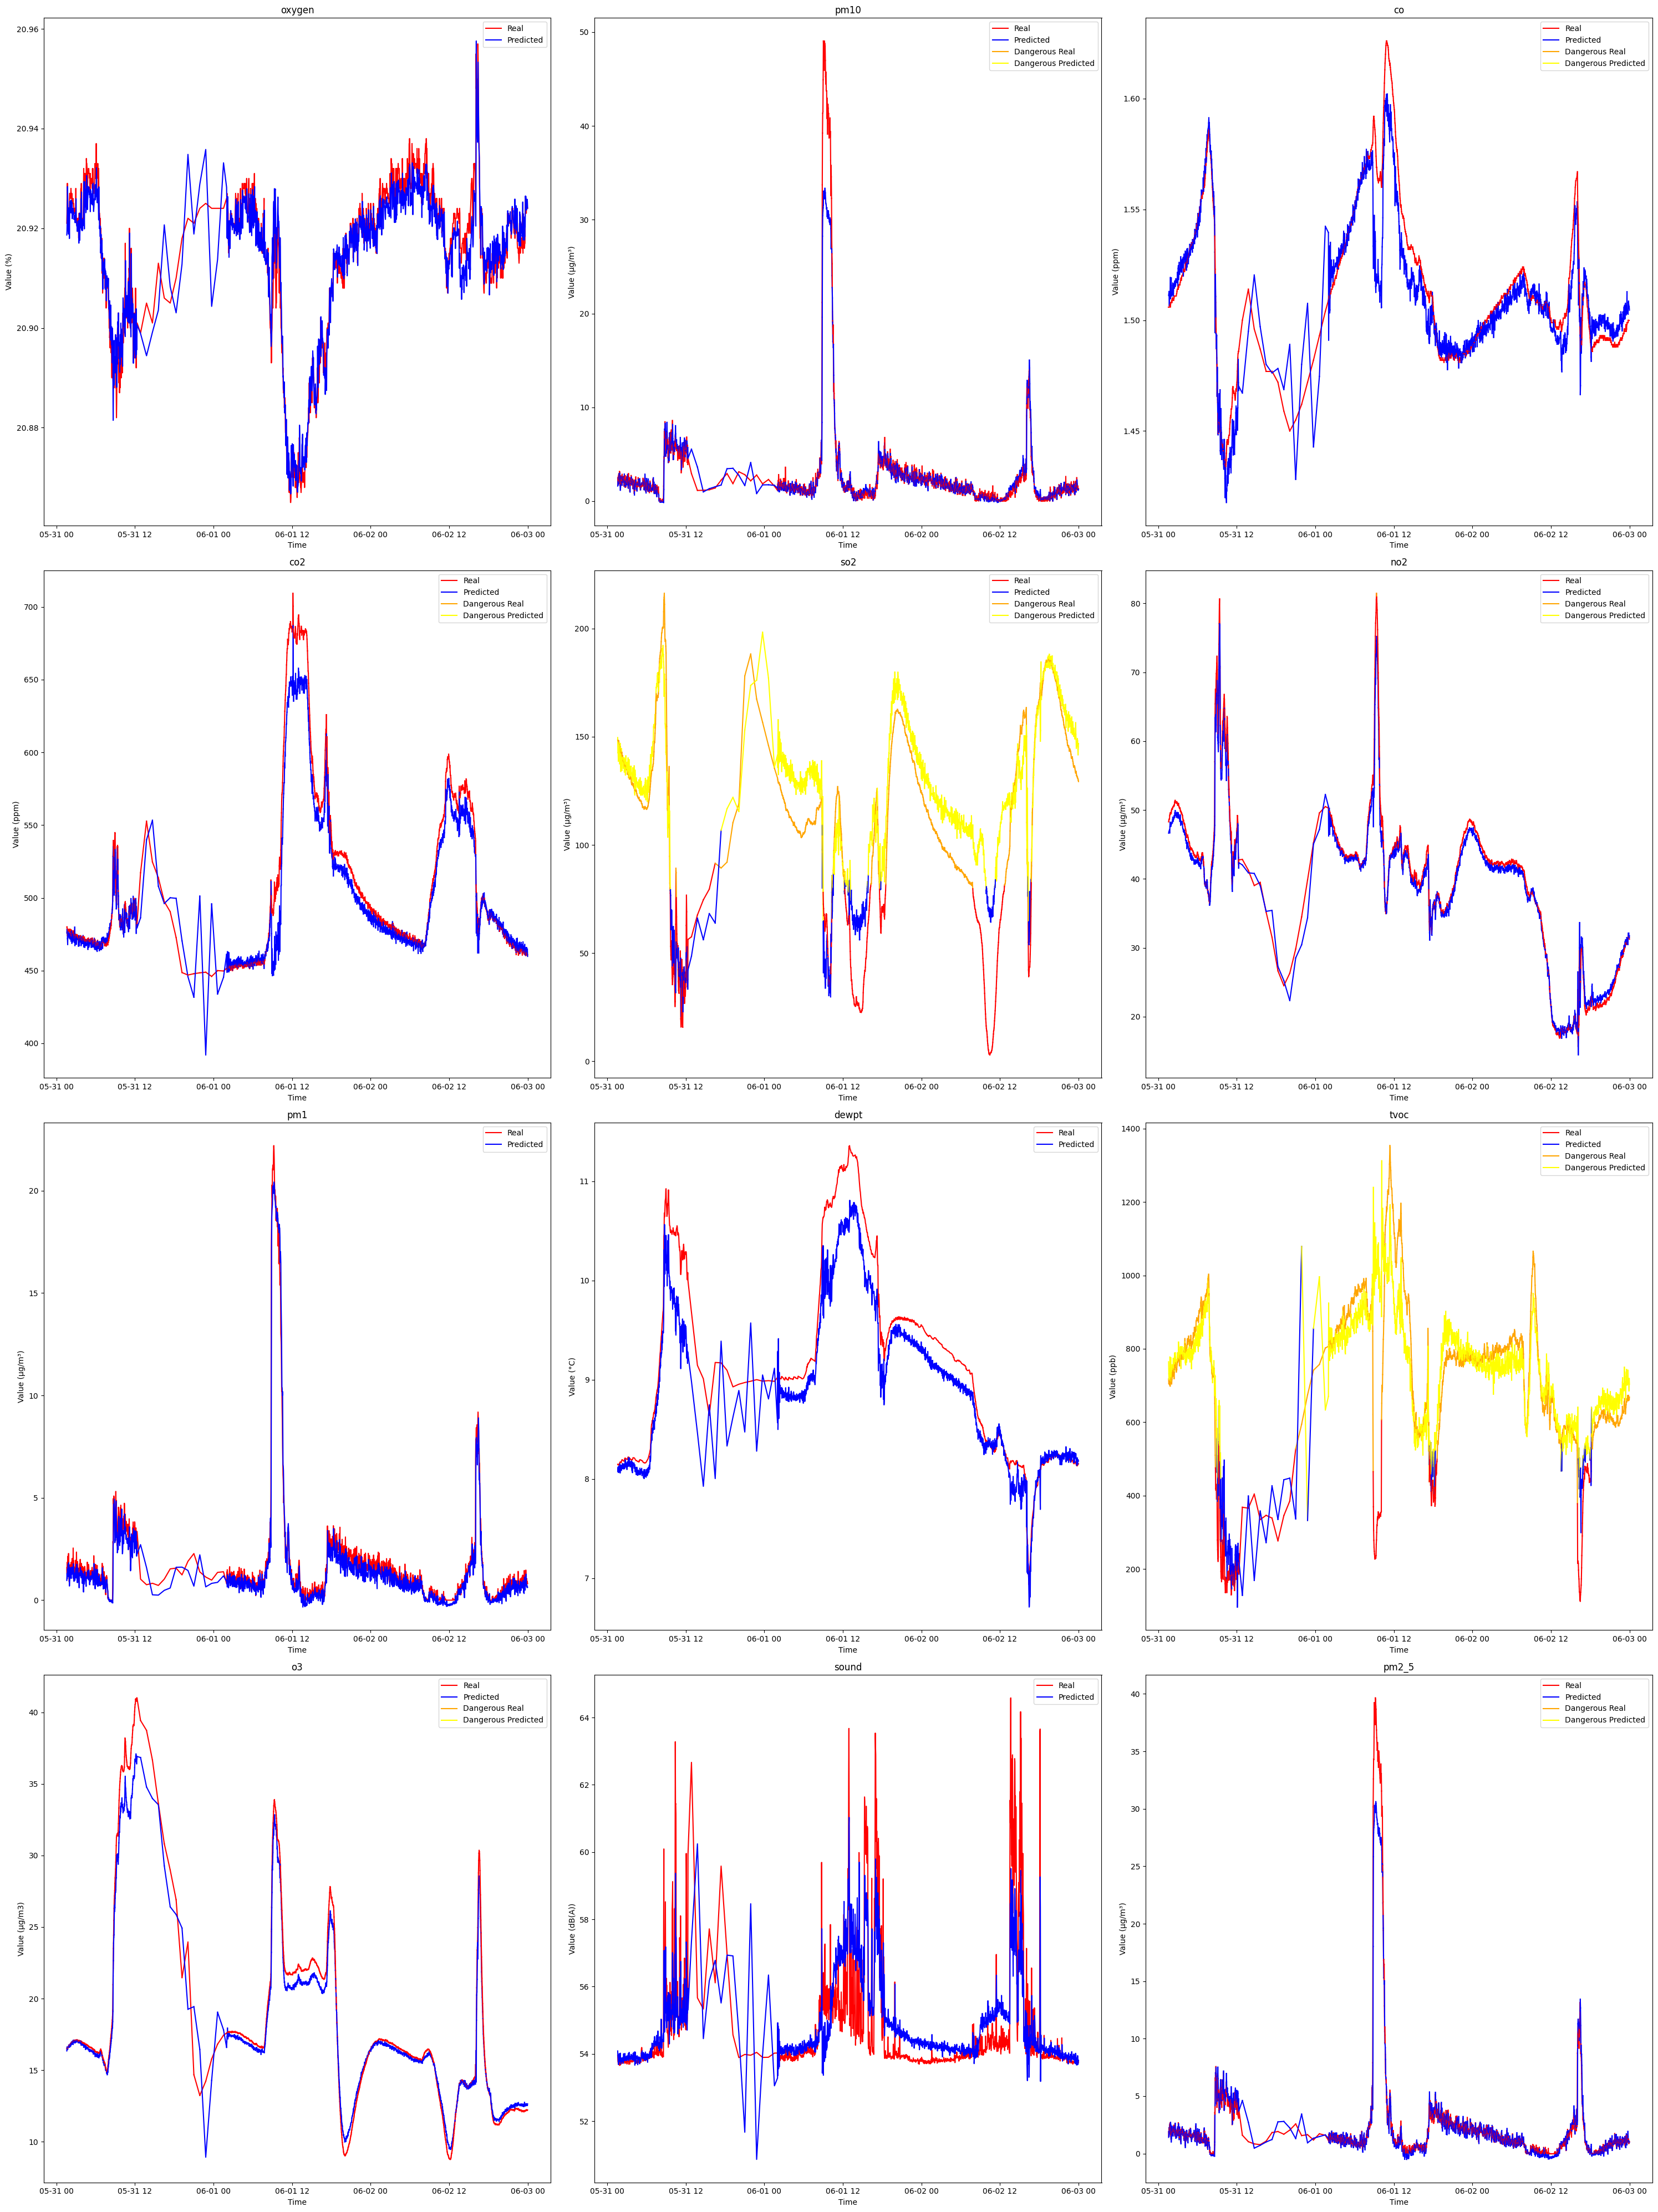

In [ ]:
dates = dates[-test_y.shape[0]:]
fig, axs = plt.subplots(4, 3, figsize=(30, 40))
feature_indices = {
    'oxygen': 0, 'pm10': 1, 'co': 2, 'co2': 3, 'so2': 4,
    'no2': 5, 'pm1': 6, 'dewpt': 7, 'tvoc': 8, 'o3' : 9, 'sound': 10, 'pm2_5': 11
}

feature_units = {
    'oxygen': '%', 'pm10': 'µg/m³', 'co': 'ppm', 'co2': 'ppm',
    'so2': 'µg/m³', 'no2': 'µg/m³', 'pm1': 'µg/m³',
    'dewpt': '°C', 'tvoc': 'ppb', 'o3': 'µg/m3', 'sound': 'dB(A)', 'pm2_5': 'µg/m³'
}

for i, (feature, index) in enumerate(feature_indices.items()):
    row = i // 3
    col = i % 3

    real_values = inv_y[:, index]
    predicted_values = inv_yhat[:, index]

    axs[row, col].set_title(feature)
    axs[row, col].set_xlabel('Time')
    axs[row, col].set_ylabel(f'Value ({feature_units[feature]})')

    if feature in danger_limits:
        if isinstance(danger_limits[feature], tuple):
            lower, upper = danger_limits[feature]
            real_colors = ['orange' if (x < lower or x > upper) else 'red' for x in real_values]
            pred_colors = ['yellow' if (x < lower or x > upper) else 'blue' for x in predicted_values]
        else:
            limit = danger_limits[feature]
            real_colors = ['orange' if x > limit else 'red' for x in real_values]
            pred_colors = ['yellow' if x > limit else 'blue' for x in predicted_values]

        for j in range(len(dates) - 1):
            axs[row, col].plot(dates[j:j+2], real_values[j:j+2], color=real_colors[j])
            axs[row, col].plot(dates[j:j+2], predicted_values[j:j+2], color=pred_colors[j])
    else:
        axs[row, col].plot(dates, real_values, color='red', label='Real')
        axs[row, col].plot(dates, predicted_values, color='blue', label='Predicted')

    axs[row, col].legend()

for ax in axs.flat:
    handles, labels = ax.get_legend_handles_labels()
    if not labels:
        ax.plot([], [], color='red', label='Real')
        ax.plot([], [], color='blue', label='Predicted')
        ax.plot([], [], color='orange', label='Dangerous Real')
        ax.plot([], [], color='yellow', label='Dangerous Predicted')
    ax.legend()

plt.tight_layout()
plt.show()
# for i, (feature, index) in enumerate(feature_indices.items()):
#     row = i // 3
#     col = i % 3

#     axs[row, col].plot(dates,inv_y[:, index], color='red', label='Real')
#     axs[row, col].plot(dates,inv_yhat[:, index], color='blue', label='Predicted')
#     axs[row, col].set_title(feature)
#     axs[row, col].set_xlabel('Time')
#     axs[row, col].set_ylabel(f'Value ({feature_units[feature]})')
#     axs[row, col].legend()

# plt.tight_layout()
# plt.show()

In [ ]:
selected_columns2 = [i for i in range(n_features) if i not in [12, 13, 14]]
inv_yhat = inv_yhat[:, selected_columns2]
inv_y = inv_y[:, selected_columns2]
print(inv_y.shape, inv_yhat.shape)
feature_names = ['oxygen', 'pm10', 'co', 'co2', 'so2', 'no2', 'pm1', 'dewpt', 'tvoc', 'o3', 'sound', 'pm2_5']

for i, feature in enumerate(feature_names):
    rmse = sqrt(mean_squared_error(inv_y[:, i], inv_yhat[:, i]))
    print(f'Test RMSE for {feature}: {rmse:.3f}')

(1707, 12) (1707, 12)
Test RMSE for oxygen: 0.004
Test RMSE for pm10: 2.027
Test RMSE for co: 0.013
Test RMSE for co2: 14.474
Test RMSE for so2: 22.009
Test RMSE for no2: 1.439
Test RMSE for pm1: 0.560
Test RMSE for dewpt: 0.341
Test RMSE for tvoc: 137.742
Test RMSE for o3: 1.013
Test RMSE for sound: 1.158
Test RMSE for pm2_5: 1.268


In [ ]:
## PM2.5 Sub-Index calculation
def get_PM25_subindex(x):
    if x <= 30:
        return x * 50 / 30
    elif x <= 60:
        return 50 + (x - 30) * 50 / 30
    elif x <= 90:
        return 100 + (x - 60) * 100 / 30
    elif x <= 120:
        return 200 + (x - 90) * 100 / 30
    elif x <= 250:
        return 300 + (x - 120) * 100 / 130
    elif x > 250:
        return 400 + (x - 250) * 100 / 130
    else:
        return 0

inv_yhat_PM25_values = inv_yhat[:, 11]
inv_y_PM25_values = inv_y[:, 11]

inv_yhat_PM25 = np.array([get_PM25_subindex(x) for x in inv_yhat_PM25_values]).astype(float)
inv_y_PM25 = np.array([get_PM25_subindex(x) for x in inv_y_PM25_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_PM25.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_PM25.reshape(-1, 1)))

In [ ]:
## PM10 Sub-Index calculation
def get_PM10_subindex(x):
    if x <= 50:
        return x
    elif x <= 100:
        return x
    elif x <= 250:
        return 100 + (x - 100) * 100 / 150
    elif x <= 350:
        return 200 + (x - 250)
    elif x <= 430:
        return 300 + (x - 350) * 100 / 80
    elif x > 430:
        return 400 + (x - 430) * 100 / 80
    else:
        return 0

inv_yhat_PM10_values = inv_yhat[:, 1]
inv_y_PM10_values = inv_y[:, 1]

inv_yhat_PM10 = np.array([get_PM10_subindex(x) for x in inv_yhat_PM10_values]).astype(float)
inv_y_PM10 = np.array([get_PM10_subindex(x) for x in inv_y_PM10_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_PM10.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_PM10.reshape(-1, 1)))

In [ ]:
## SO2 Sub-Index calculation
def get_SO2_subindex(x):
    if x <= 40:
        return x * 50 / 40
    elif x <= 80:
        return 50 + (x - 40) * 50 / 40
    elif x <= 380:
        return 100 + (x - 80) * 100 / 300
    elif x <= 800:
        return 200 + (x - 380) * 100 / 420
    elif x <= 1600:
        return 300 + (x - 800) * 100 / 800
    elif x > 1600:
        return 400 + (x - 1600) * 100 / 800
    else:
        return 0

inv_yhat_SO2_values = inv_yhat[:, 4]
inv_y_SO2_values = inv_y[:, 4]

inv_yhat_SO2= np.array([get_SO2_subindex(x) for x in inv_yhat_SO2_values]).astype(float)
inv_y_SO2 = np.array([get_SO2_subindex(x) for x in inv_y_SO2_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_SO2.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_SO2.reshape(-1, 1)))

In [ ]:
## NO2 Sub-Index calculation
def get_NO2_subindex(x):
    if x <= 40:
        return x * 50 / 40
    elif x <= 80:
        return 50 + (x - 40) * 50 / 40
    elif x <= 180:
        return 100 + (x - 80) * 100 / 100
    elif x <= 280:
        return 200 + (x - 180) * 100 / 100
    elif x <= 400:
        return 300 + (x - 280) * 100 / 120
    elif x > 400:
        return 400 + (x - 400) * 100 / 120
    else:
        return 0

inv_yhat_NO2_values = inv_yhat[:, 5]
inv_y_NO2_values = inv_y[:, 5]

inv_yhat_NO2= np.array([get_NO2_subindex(x) for x in inv_yhat_NO2_values]).astype(float)
inv_y_NO2 = np.array([get_NO2_subindex(x) for x in inv_y_NO2_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_NO2.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_NO2.reshape(-1, 1)))

In [ ]:
## CO Sub-Index calculation
def get_CO_subindex(x):
    if x <= 1:
        return x * 50 / 1
    elif x <= 2:
        return 50 + (x - 1) * 50 / 1
    elif x <= 10:
        return 100 + (x - 2) * 100 / 8
    elif x <= 17:
        return 200 + (x - 10) * 100 / 7
    elif x <= 34:
        return 300 + (x - 17) * 100 / 17
    elif x > 34:
        return 400 + (x - 34) * 100 / 17
    else:
        return 0

inv_yhat_CO_values = inv_yhat[:, 2]
inv_y_CO_values = inv_y[:, 2]

inv_yhat_CO= np.array([get_CO_subindex(x) for x in inv_yhat_CO_values]).astype(float)
inv_y_CO = np.array([get_CO_subindex(x) for x in inv_y_CO_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_CO.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_CO.reshape(-1, 1)))

In [ ]:
## O3 Sub-Index calculation
def get_O3_subindex(x):
    if x <= 50:
        return x * 50 / 50
    elif x <= 100:
        return 50 + (x - 50) * 50 / 50
    elif x <= 168:
        return 100 + (x - 100) * 100 / 68
    elif x <= 208:
        return 200 + (x - 168) * 100 / 40
    elif x <= 748:
        return 300 + (x - 208) * 100 / 539
    elif x > 748:
        return 400 + (x - 400) * 100 / 539
    else:
        return 0

inv_yhat_O3_values = inv_yhat[:, 9]
inv_y_O3_values = inv_y[:, 9]

inv_yhat_O3= np.array([get_O3_subindex(x) for x in inv_yhat_O3_values]).astype(float)
inv_y_O3 = np.array([get_O3_subindex(x) for x in inv_y_O3_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_O3.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_O3.reshape(-1, 1)))

In [ ]:
## AQI bucketing
def get_AQI_bucket(x):
    if x <= 50:
        return "Good"
    elif x <= 100:
        return "Satisfactory"
    elif x <= 200:
        return "Moderate"
    elif x <= 300:
        return "Poor"
    elif x <= 400:
        return "Very Poor"
    elif x > 400:
        return "Severe"
    else:
        return np.NaN

PM25_SubIndex_col = 12
PM10_SubIndex_col = 13
SO2_SubIndex_col = 14
NO2_SubIndex_col = 15
CO_SubIndex_col = 16
O3_SubIndex_col = 17

inv_yhat_Checks = ((inv_yhat[:, PM25_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, PM10_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, SO2_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, NO2_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, CO_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, O3_SubIndex_col] > 0).astype(int))

inv_y_Checks = ((inv_y[:, PM25_SubIndex_col] > 0).astype(int) +
                (inv_y[:, PM10_SubIndex_col] > 0).astype(int) +
                (inv_y[:, SO2_SubIndex_col] > 0).astype(int) +
                (inv_y[:, NO2_SubIndex_col] > 0).astype(int) +
                (inv_y[:, CO_SubIndex_col] > 0).astype(int) +
                (inv_y[:, O3_SubIndex_col] > 0).astype(int))


inv_yhat_AQI_calculated = np.max(inv_yhat[:, [PM25_SubIndex_col, PM10_SubIndex_col, SO2_SubIndex_col, NO2_SubIndex_col, CO_SubIndex_col, O3_SubIndex_col]], axis=1)
inv_y_AQI_calculated = np.max(inv_y[:, [PM25_SubIndex_col, PM10_SubIndex_col, SO2_SubIndex_col, NO2_SubIndex_col, CO_SubIndex_col, O3_SubIndex_col]], axis=1)

inv_yhat_AQI_calculated[(inv_yhat[:, PM25_SubIndex_col] + inv_yhat[:, PM10_SubIndex_col] <= 0) | (inv_yhat_Checks < 3)] = np.NaN
inv_y_AQI_calculated[(inv_y[:, PM25_SubIndex_col] + inv_y[:, PM10_SubIndex_col] <= 0) | (inv_y_Checks < 3)] = np.NaN

inv_yhat_AQI_bucket_calculated = np.array([get_AQI_bucket(x) for x in inv_yhat_AQI_calculated])
inv_y_AQI_bucket_calculated = np.array([get_AQI_bucket(x) for x in inv_y_AQI_calculated])

inv_yhat = np.hstack((inv_yhat, inv_yhat_AQI_calculated.reshape(-1, 1), inv_yhat_Checks.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_AQI_calculated.reshape(-1, 1), inv_y_Checks.reshape(-1, 1)))

inv_yhat_df = pd.DataFrame(inv_yhat, columns=[f'col{i}' for i in range(inv_yhat.shape[1] - 2)] + ['AQI_calculated', 'Checks'])
inv_y_df = pd.DataFrame(inv_y, columns=[f'col{i}' for i in range(inv_y.shape[1] - 2)] + ['AQI_calculated', 'Checks'])

inv_yhat_df['AQI_bucket_calculated'] = inv_yhat_AQI_bucket_calculated
inv_y_df['AQI_bucket_calculated'] = inv_y_AQI_bucket_calculated

print(inv_yhat_df.head(5))
print(inv_y_df.head(5))

        col0      col1      col2        col3        col4       col5      col6  \
0  20.918657  1.612314  1.511113  475.833038  149.632401  46.635513  0.963502   
1  20.919508  2.150816  1.511863  478.514740  142.627640  46.739830  1.296826   
2  20.922262  1.712124  1.512963  478.003540  142.526688  46.920258  1.042762   
3  20.928349  2.498990  1.506634  471.936768  138.713684  46.858246  1.531880   
4  20.926683  2.333214  1.510682  467.971191  142.667725  47.146313  1.433640   

       col7        col8       col9  ...     col11     col12     col13  \
0  8.075816  764.698120  16.342382  ...  1.409673  2.349455  1.612314   
1  8.113472  731.814209  16.605921  ...  1.920497  3.200828  2.150816   
2  8.122086  716.681702  16.521830  ...  1.514276  2.523794  1.712124   
3  8.065466  724.271240  16.437113  ...  2.261156  3.768593  2.498990   
4  8.084861  745.167480  16.462786  ...  2.110398  3.517329  2.333214   

        col14      col15      col16      col17  AQI_calculated  Checks  \


In [ ]:
from sklearn.metrics import accuracy_score
accuracy_normalized = accuracy_score(inv_y[:,-1], inv_yhat[:,-1], normalize=True)
print("Accuracy: " + str(accuracy_normalized))

Accuracy: 0.9232571763327475


In [ ]:
num_correct = accuracy_score(inv_y[:,-1], inv_yhat[:,-1], normalize=False)
print(num_correct) 

1576.0


**Multivariate GRU Predictive Modeling**

In [ ]:
values = data.values

values = values.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

reframed = series_to_supervised(scaled, 1, 1)
reframed.drop(reframed.columns[[-1,-2,-3]], axis=1, inplace=True)
reframed.head()

var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.000000   0.189904   0.848387   0.149366   0.996458   0.431124   
2   0.005791   0.184298   0.840322   0.141075   0.996445   0.430600   
3   0.000000   0.210760   0.833871   0.139532   0.996406   0.434559   
4   0.023125   0.187009   0.829032   0.139468   0.996424   0.443796   
5   0.017342   0.167540   0.824193   0.140394   0.996436   0.453471   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  ...   var3(t)   var4(t)  \
1   0.290591   0.325957        0.0    0.684472  ...  0.840322  0.141075   
2   0.291717   0.321531        0.0    0.683219  ...  0.833871  0.139532   
3   0.300005   0.320755        0.0    0.681139  ...  0.829032  0.139468   
4   0.304959   0.320910        0.0    0.680407  ...  0.824193  0.140394   
5   0.263208   0.319124        0.0    0.677807  ...  0.817742  0.136453   

    var5(t)   var6(t)   var7(t)   var8(t)  var9(t)  var10(t)  var11(t)  \
1  0.996445  0.430600  0.291717  0.321531      0.0  0.683219  0.452520   
2  0.996406  0.434559  0.300005  0.320755      0.0  0.681139  0.463491   
3  0.996424  0.443796  0.304959  0.320910      0.0  0.680407  0.594671   
4  0.996436  0.453471  0.263208  0.319124      0.0  0.677807  0.628608   
5  0.996360  0.460178  0.288835  0.316950      0.0  0.675136  0.503492   

   var12(t)  
1  0.206875  
2  0.222687  
3  0.206572  
4  0.173711  
5  0.206244  

[5 rows x 27 columns]

In [ ]:
n_temps = 1440
n_features = 15

reframed = series_to_supervised(scaled, n_temps, 1)

In [ ]:
reframed.drop(reframed.columns[[-1,-2,-3]], axis=1, inplace=True)
reframed.head(10)

var1(t-1440)  var2(t-1440)  var3(t-1440)  var4(t-1440)  var5(t-1440)  \
1440      0.000000      0.189904      0.848387      0.149366      0.996458   
1441      0.005791      0.184298      0.840322      0.141075      0.996445   
1442      0.000000      0.210760      0.833871      0.139532      0.996406   
1443      0.023125      0.187009      0.829032      0.139468      0.996424   
1444      0.017342      0.167540      0.824193      0.140394      0.996436   
1445      0.052032      0.179446      0.817742      0.136453      0.996360   
1446      0.052032      0.165583      0.809677      0.129000      0.996343   
1447      0.063583      0.197468      0.801613      0.128302      0.996262   
1448      0.057808      0.198426      0.795161      0.133763      0.996079   
1449      0.098267      0.184787      0.791935      0.125911      0.996032   

      var6(t-1440)  var7(t-1440)  var8(t-1440)  var9(t-1440)  var10(t-1440)  \
1440      0.431124      0.290591      0.325957           0.0       0.684472   
1441      0.430600      0.291717      0.321531           0.0       0.683219   
1442      0.434559      0.300005      0.320755           0.0       0.681139   
1443      0.443796      0.304959      0.320910           0.0       0.680407   
1444      0.453471      0.263208      0.319124           0.0       0.677807   
1445      0.460178      0.288835      0.316950           0.0       0.675136   
1446      0.468756      0.288925      0.314232           0.0       0.670976   
1447      0.474767      0.309373      0.309341           0.0       0.665280   
1448      0.475073      0.326217      0.304760           0.0       0.660529   
1449      0.475311      0.317209      0.303440           0.0       0.658497   

      ...   var3(t)   var4(t)   var5(t)   var6(t)   var7(t)   var8(t)  \
1440  ...  0.500000  0.200811  0.139095  0.543295  0.000000  0.302586   
1441  ...  0.501613  0.205701  0.139844  0.546806  0.000000  0.303207   
1442  ...  0.501613  0.204943  0.140383  0.549420  0.000000  0.304061   
1443  ...  0.500000  0.204206  0.140742  0.548342  0.000000  0.304527   
1444  ...  0.500000  0.204129  0.140886  0.546090  0.000000  0.306390   
1445  ...  0.501613  0.200637  0.141140  0.544554  0.000000  0.305769   
1446  ...  0.500000  0.201898  0.141533  0.540957  0.000540  0.306623   
1447  ...  0.500000  0.206556  0.141671  0.538448  0.000045  0.307477   
1448  ...  0.501613  0.207845  0.142326  0.537160  0.000000  0.307633   
1449  ...  0.501613  0.211306  0.142816  0.538467  0.000000  0.307555   

       var9(t)  var10(t)  var11(t)  var12(t)  
1440  0.046314  0.420208  0.328529  0.000000  
1441  0.046773  0.420161  0.334833  0.000000  
1442  0.047219  0.418601  0.333231  0.000000  
1443  0.047363  0.417845  0.337047  0.000000  
1444  0.047463  0.417230  0.345940  0.000000  
1445  0.049822  0.418364  0.336911  0.000000  
1446  0.047779  0.418695  0.323963  0.000303  
1447  0.047324  0.420468  0.328188  0.000025  
1448  0.046930  0.421957  0.314150  0.000000  
1449  0.047382  0.422406  0.332039  0.000000  

[10 rows x 21612 columns]

In [ ]:
values = reframed.values
num_rows = data.shape[0]
train_samples = int(num_rows * 0.9)

train = values[:train_samples, :]
test = values[train_samples:, :]
n_obs = n_temps * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features+3:]
test_X, test_y = test[:, :n_obs], test[:, -n_features+3:]
print( train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(28321, 21600) (28321, 12) (1707, 21600) (1707, 12)


In [ ]:
train_X = train_X.reshape((train_X.shape[0], n_temps, n_features))
test_X = test_X.reshape((test_X.shape[0], n_temps, n_features))

print(test_X.shape,train_X.shape)

(1707, 1440, 15) (28321, 1440, 15)


In [ ]:
model = Sequential()
model.add(GRU(30, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.3))
model.add(Dense(12))
model.compile(loss='mae', optimizer='adam')
print(model.summary())

d:\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 30)             │         4,230 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 12)             │           372 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,602 (17.98 KB)

 Trainable params: 4,602 (17.98 KB)

 Non-trainable params: 0 (0.00 B)

None


Epoch 1/100
222/222 - 114s - 514ms/step - loss: 0.1459 - val_loss: 0.0601
Epoch 2/100
222/222 - 111s - 502ms/step - loss: 0.0862 - val_loss: 0.0488
Epoch 3/100
222/222 - 110s - 495ms/step - loss: 0.0656 - val_loss: 0.0412
Epoch 4/100
222/222 - 113s - 508ms/step - loss: 0.0543 - val_loss: 0.0367
Epoch 5/100
222/222 - 109s - 490ms/step - loss: 0.0474 - val_loss: 0.0348
Epoch 6/100
222/222 - 109s - 492ms/step - loss: 0.0422 - val_loss: 0.0308
Epoch 7/100
222/222 - 109s - 493ms/step - loss: 0.0385 - val_loss: 0.0281
Epoch 8/100
222/222 - 108s - 484ms/step - loss: 0.0360 - val_loss: 0.0267
Epoch 9/100
222/222 - 108s - 488ms/step - loss: 0.0338 - val_loss: 0.0258
Epoch 10/100
222/222 - 108s - 486ms/step - loss: 0.0329 - val_loss: 0.0253
Epoch 11/100
222/222 - 108s - 488ms/step - loss: 0.0316 - val_loss: 0.0249
Epoch 12/100
222/222 - 108s - 487ms/step - loss: 0.0310 - val_loss: 0.0248
Epoch 13/100
222/222 - 108s - 487ms/step - loss: 0.0306 - val_loss: 0.0254
Epoch 14/100
222/222 - 108s - 489m

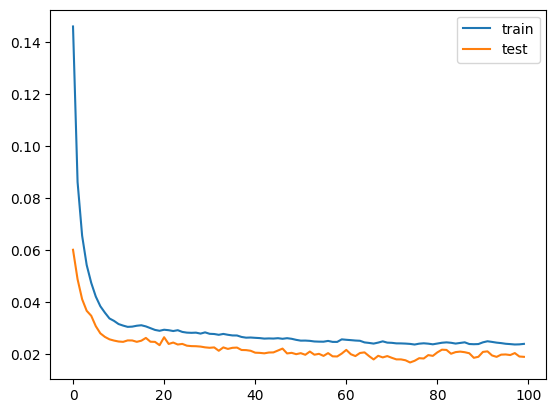

In [ ]:
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# history = model.fit(train_X, train_y, epochs=100, batch_size=128, validation_data=(test_X, test_y), verbose=2, shuffle=False, callbacks=[early_stopping])
history = model.fit(train_X, train_y, epochs=100, batch_size=128, validation_data=(test_X, test_y), verbose=2, shuffle=False)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_temps*n_features))

selected_columns = [i for i in range(test_X.shape[1]) if i in [12, 13, 14]]

inv_yhat = np.concatenate((yhat, test_X[:, selected_columns]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
# inv_yhat = inv_yhat[:, selected_columns]

test_y = test_y.reshape(len(test_y), test_y.shape[1])
inv_y = np.concatenate((test_y, test_X[:, selected_columns]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,:-3]
inv_y_df = pd.DataFrame(inv_y)
print(inv_y_df.head())

54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step
          0      1      2           3           4          5      6      7   \
0  20.921000  2.475  1.506  479.887970  148.612000  48.271999  1.595  8.146   
1  20.923000  1.821  1.506  480.033997  148.227005  48.425999  1.291  8.151   
2  20.929001  2.565  1.506  478.789001  148.326004  48.632000  1.855  8.149   
3  20.929001  2.167  1.506  474.342010  148.130005  48.690002  1.599  8.143   
4  20.926001  2.737  1.506  475.026001  148.029999  48.692001  1.796  8.140   

           8          9          10     11  
0  717.888000  16.506001  53.962002  1.900  
1  705.403992  16.485001  53.779999  1.519  
2  704.439087  16.494999  53.749001  2.229  
3  710.427002  16.527998  53.685001  2.133  
4  701.901978  16.542997  53.720001  2.199  


In [ ]:
danger_limits = {
    'pm10': 101,
    'co': 201,
    'co2': 1001,
    'so2': 81,
    'no2': 81,
    'tvoc': 500,
    'o3': 100,
    'pm2_5': 61,
}

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

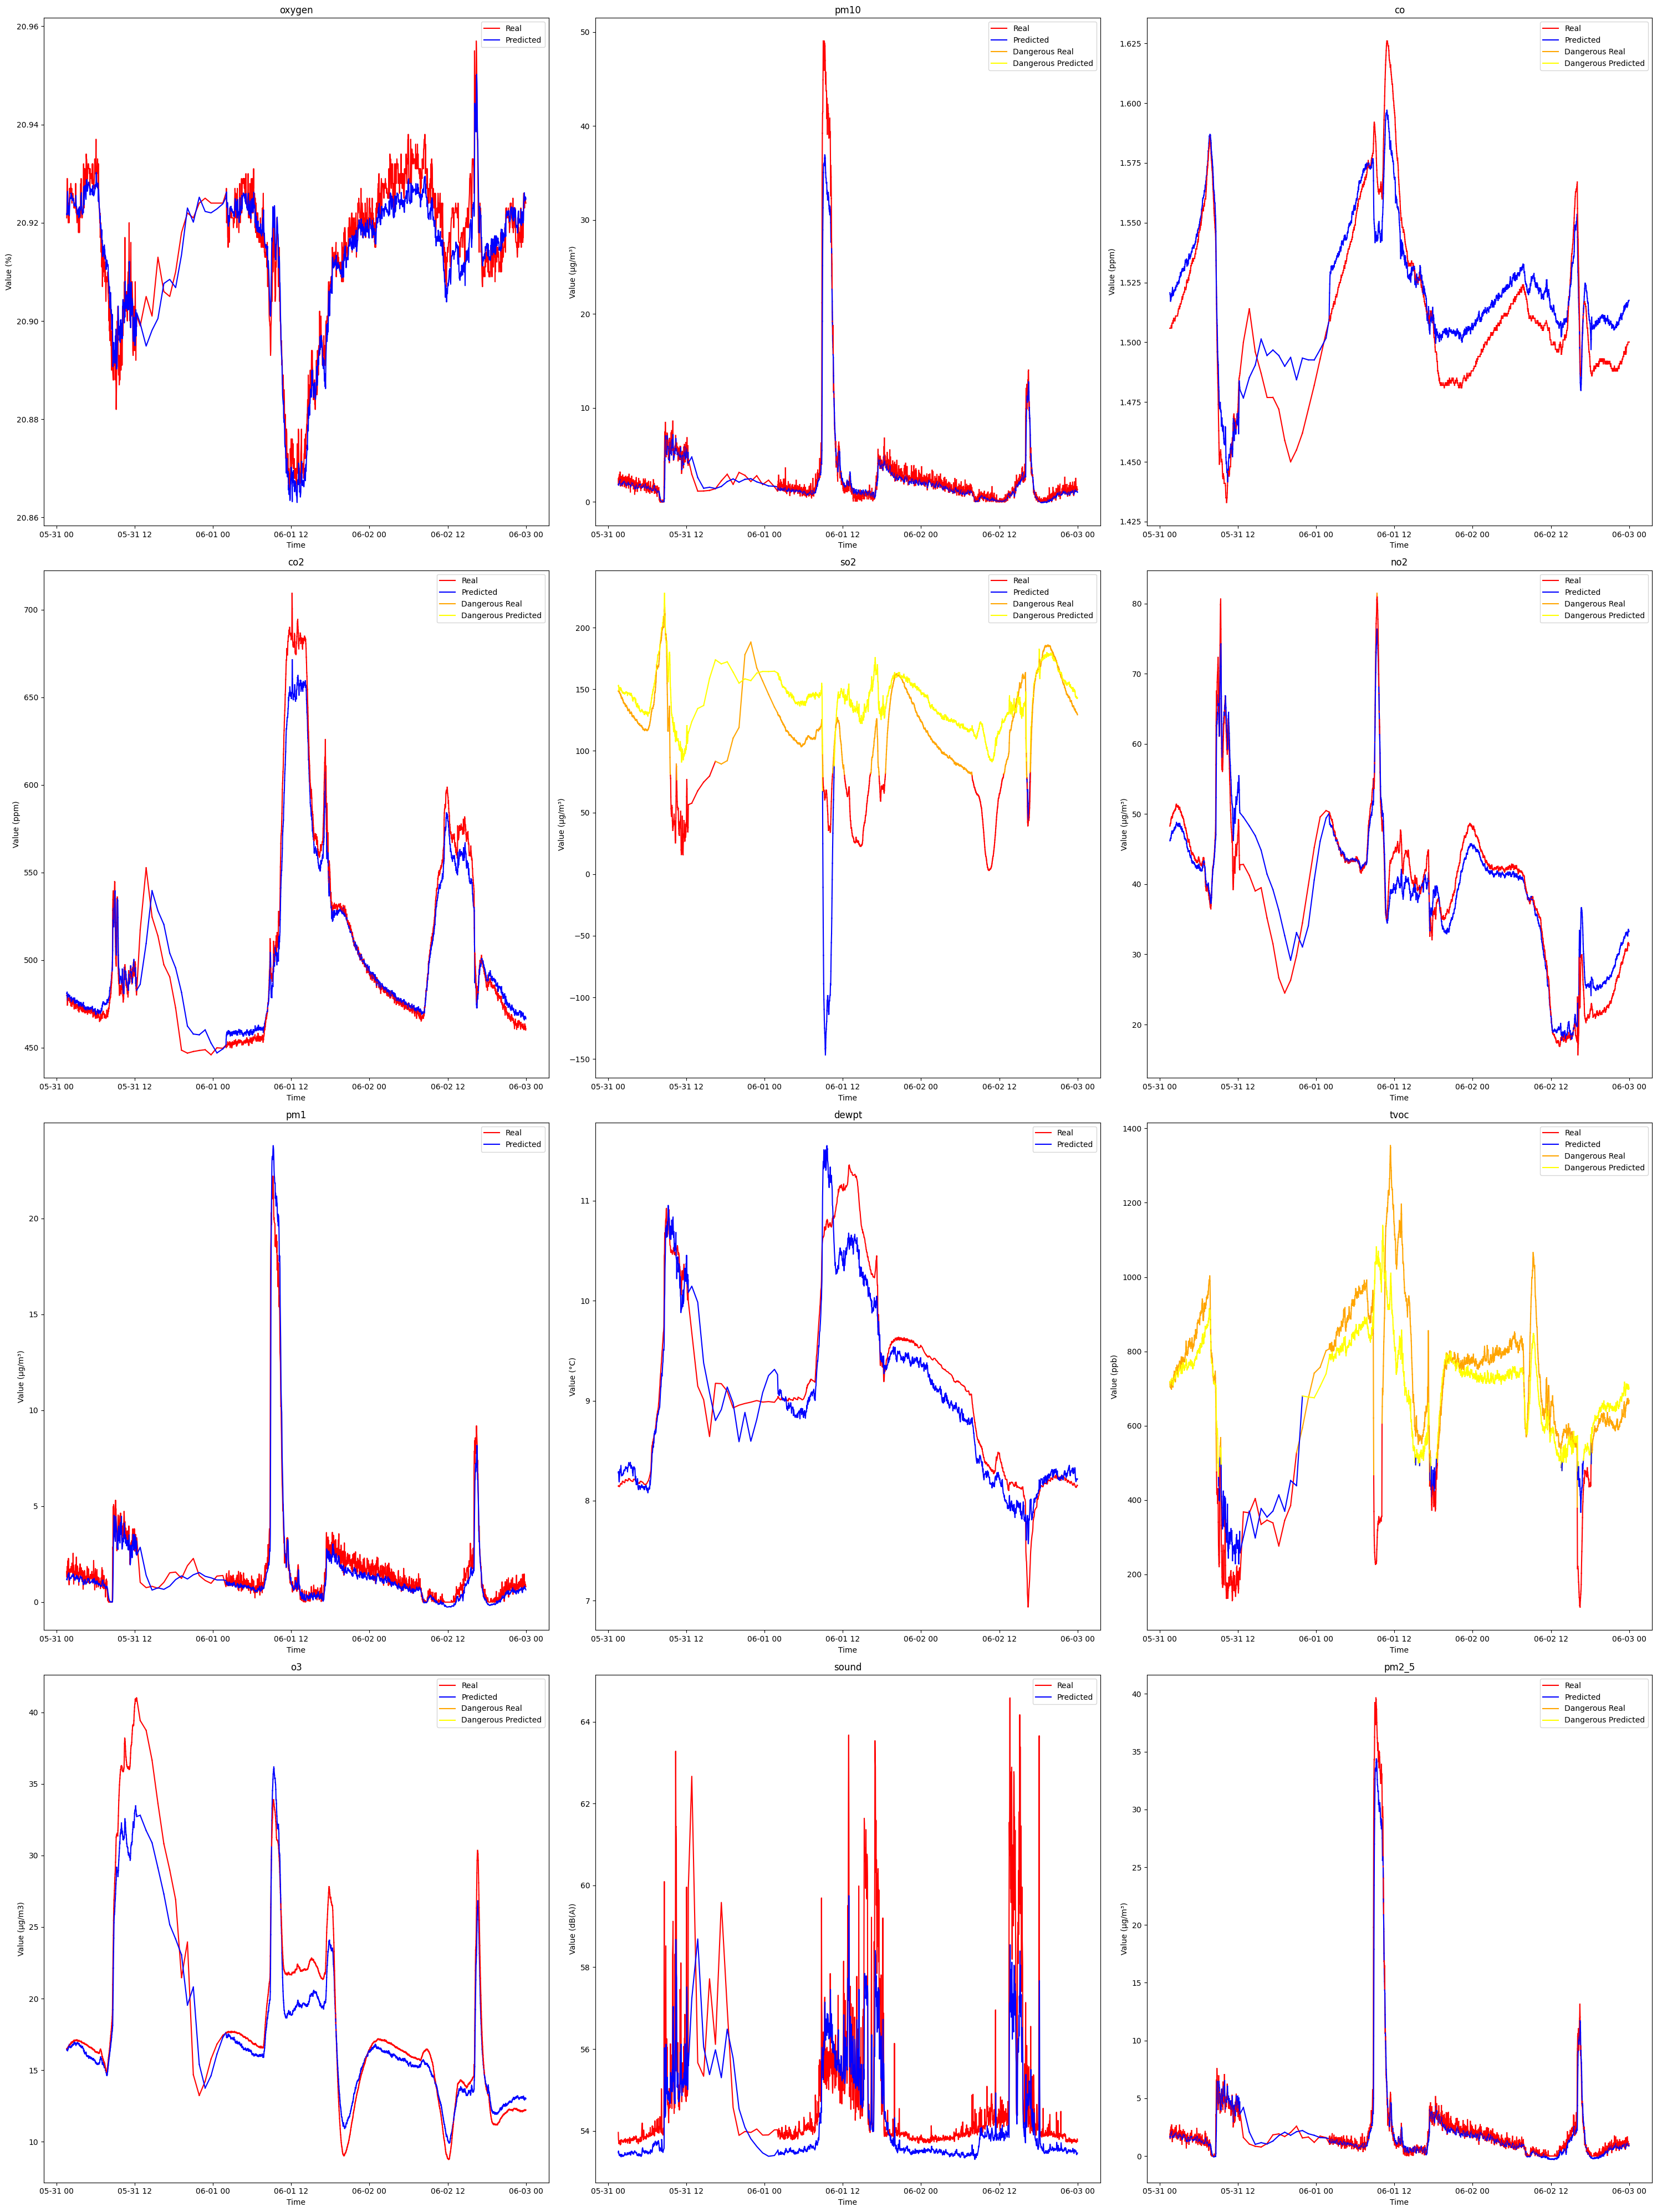

In [ ]:
dates = dates[-test_y.shape[0]:]
fig, axs = plt.subplots(4, 3, figsize=(30, 40))
feature_indices = {
    'oxygen': 0, 'pm10': 1, 'co': 2, 'co2': 3, 'so2': 4,
    'no2': 5, 'pm1': 6, 'dewpt': 7, 'tvoc': 8, 'o3' : 9, 'sound': 10, 'pm2_5': 11
}

feature_units = {
    'oxygen': '%', 'pm10': 'µg/m³', 'co': 'ppm', 'co2': 'ppm',
    'so2': 'µg/m³', 'no2': 'µg/m³', 'pm1': 'µg/m³',
    'dewpt': '°C', 'tvoc': 'ppb', 'o3': 'µg/m3', 'sound': 'dB(A)', 'pm2_5': 'µg/m³'
}

for i, (feature, index) in enumerate(feature_indices.items()):
    row = i // 3
    col = i % 3

    real_values = inv_y[:, index]
    predicted_values = inv_yhat[:, index]

    axs[row, col].set_title(feature)
    axs[row, col].set_xlabel('Time')
    axs[row, col].set_ylabel(f'Value ({feature_units[feature]})')

    if feature in danger_limits:
        if isinstance(danger_limits[feature], tuple):
            lower, upper = danger_limits[feature]
            real_colors = ['orange' if (x < lower or x > upper) else 'red' for x in real_values]
            pred_colors = ['yellow' if (x < lower or x > upper) else 'blue' for x in predicted_values]
        else:
            limit = danger_limits[feature]
            real_colors = ['orange' if x > limit else 'red' for x in real_values]
            pred_colors = ['yellow' if x > limit else 'blue' for x in predicted_values]

        for j in range(len(dates) - 1):
            axs[row, col].plot(dates[j:j+2], real_values[j:j+2], color=real_colors[j])
            axs[row, col].plot(dates[j:j+2], predicted_values[j:j+2], color=pred_colors[j])
    else:
        axs[row, col].plot(dates, real_values, color='red', label='Real')
        axs[row, col].plot(dates, predicted_values, color='blue', label='Predicted')

    axs[row, col].legend()

for ax in axs.flat:
    handles, labels = ax.get_legend_handles_labels()
    if not labels:
        ax.plot([], [], color='red', label='Real')
        ax.plot([], [], color='blue', label='Predicted')
        ax.plot([], [], color='orange', label='Dangerous Real')
        ax.plot([], [], color='yellow', label='Dangerous Predicted')
    ax.legend()

plt.tight_layout()
plt.show()
# for i, (feature, index) in enumerate(feature_indices.items()):
#     row = i // 3
#     col = i % 3

#     axs[row, col].plot(dates,inv_y[:, index], color='red', label='Real')
#     axs[row, col].plot(dates,inv_yhat[:, index], color='blue', label='Predicted')
#     axs[row, col].set_title(feature)
#     axs[row, col].set_xlabel('Time')
#     axs[row, col].set_ylabel(f'Value ({feature_units[feature]})')
#     axs[row, col].legend()

# plt.tight_layout()
# plt.show()

In [ ]:
selected_columns2 = [i for i in range(n_features) if i not in [12, 13, 14]]
inv_yhat = inv_yhat[:, selected_columns2]
inv_y = inv_y[:, selected_columns2]
print(inv_y.shape, inv_yhat.shape)
feature_names = ['oxygen', 'pm10', 'co', 'co2', 'so2', 'no2', 'pm1', 'dewpt', 'tvoc', 'o3', 'sound', 'pm2_5']

for i, feature in enumerate(feature_names):
    rmse = sqrt(mean_squared_error(inv_y[:, i], inv_yhat[:, i]))
    print(f'Test RMSE for {feature}: {rmse:.3f}')

(1707, 12) (1707, 12)
Test RMSE for oxygen: 0.005
Test RMSE for pm10: 1.879
Test RMSE for co: 0.014
Test RMSE for co2: 10.690
Test RMSE for so2: 48.972
Test RMSE for no2: 2.726
Test RMSE for pm1: 0.735
Test RMSE for dewpt: 0.279
Test RMSE for tvoc: 152.563
Test RMSE for o3: 1.904
Test RMSE for sound: 1.172
Test RMSE for pm2_5: 1.155


In [ ]:
## PM2.5 Sub-Index calculation
def get_PM25_subindex(x):
    if x <= 30:
        return x * 50 / 30
    elif x <= 60:
        return 50 + (x - 30) * 50 / 30
    elif x <= 90:
        return 100 + (x - 60) * 100 / 30
    elif x <= 120:
        return 200 + (x - 90) * 100 / 30
    elif x <= 250:
        return 300 + (x - 120) * 100 / 130
    elif x > 250:
        return 400 + (x - 250) * 100 / 130
    else:
        return 0

inv_yhat_PM25_values = inv_yhat[:, 11]
inv_y_PM25_values = inv_y[:, 11]

inv_yhat_PM25 = np.array([get_PM25_subindex(x) for x in inv_yhat_PM25_values]).astype(float)
inv_y_PM25 = np.array([get_PM25_subindex(x) for x in inv_y_PM25_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_PM25.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_PM25.reshape(-1, 1)))

In [ ]:
## PM10 Sub-Index calculation
def get_PM10_subindex(x):
    if x <= 50:
        return x
    elif x <= 100:
        return x
    elif x <= 250:
        return 100 + (x - 100) * 100 / 150
    elif x <= 350:
        return 200 + (x - 250)
    elif x <= 430:
        return 300 + (x - 350) * 100 / 80
    elif x > 430:
        return 400 + (x - 430) * 100 / 80
    else:
        return 0

inv_yhat_PM10_values = inv_yhat[:, 1]
inv_y_PM10_values = inv_y[:, 1]

inv_yhat_PM10 = np.array([get_PM10_subindex(x) for x in inv_yhat_PM10_values]).astype(float)
inv_y_PM10 = np.array([get_PM10_subindex(x) for x in inv_y_PM10_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_PM10.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_PM10.reshape(-1, 1)))

In [ ]:
## SO2 Sub-Index calculation
def get_SO2_subindex(x):
    if x <= 40:
        return x * 50 / 40
    elif x <= 80:
        return 50 + (x - 40) * 50 / 40
    elif x <= 380:
        return 100 + (x - 80) * 100 / 300
    elif x <= 800:
        return 200 + (x - 380) * 100 / 420
    elif x <= 1600:
        return 300 + (x - 800) * 100 / 800
    elif x > 1600:
        return 400 + (x - 1600) * 100 / 800
    else:
        return 0

inv_yhat_SO2_values = inv_yhat[:, 4]
inv_y_SO2_values = inv_y[:, 4]

inv_yhat_SO2= np.array([get_SO2_subindex(x) for x in inv_yhat_SO2_values]).astype(float)
inv_y_SO2 = np.array([get_SO2_subindex(x) for x in inv_y_SO2_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_SO2.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_SO2.reshape(-1, 1)))

In [ ]:
## NO2 Sub-Index calculation
def get_NO2_subindex(x):
    if x <= 40:
        return x * 50 / 40
    elif x <= 80:
        return 50 + (x - 40) * 50 / 40
    elif x <= 180:
        return 100 + (x - 80) * 100 / 100
    elif x <= 280:
        return 200 + (x - 180) * 100 / 100
    elif x <= 400:
        return 300 + (x - 280) * 100 / 120
    elif x > 400:
        return 400 + (x - 400) * 100 / 120
    else:
        return 0

inv_yhat_NO2_values = inv_yhat[:, 5]
inv_y_NO2_values = inv_y[:, 5]

inv_yhat_NO2= np.array([get_NO2_subindex(x) for x in inv_yhat_NO2_values]).astype(float)
inv_y_NO2 = np.array([get_NO2_subindex(x) for x in inv_y_NO2_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_NO2.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_NO2.reshape(-1, 1)))

In [ ]:
## CO Sub-Index calculation
def get_CO_subindex(x):
    if x <= 1:
        return x * 50 / 1
    elif x <= 2:
        return 50 + (x - 1) * 50 / 1
    elif x <= 10:
        return 100 + (x - 2) * 100 / 8
    elif x <= 17:
        return 200 + (x - 10) * 100 / 7
    elif x <= 34:
        return 300 + (x - 17) * 100 / 17
    elif x > 34:
        return 400 + (x - 34) * 100 / 17
    else:
        return 0

inv_yhat_CO_values = inv_yhat[:, 2]
inv_y_CO_values = inv_y[:, 2]

inv_yhat_CO= np.array([get_CO_subindex(x) for x in inv_yhat_CO_values]).astype(float)
inv_y_CO = np.array([get_CO_subindex(x) for x in inv_y_CO_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_CO.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_CO.reshape(-1, 1)))

In [ ]:
## O3 Sub-Index calculation
def get_O3_subindex(x):
    if x <= 50:
        return x * 50 / 50
    elif x <= 100:
        return 50 + (x - 50) * 50 / 50
    elif x <= 168:
        return 100 + (x - 100) * 100 / 68
    elif x <= 208:
        return 200 + (x - 168) * 100 / 40
    elif x <= 748:
        return 300 + (x - 208) * 100 / 539
    elif x > 748:
        return 400 + (x - 400) * 100 / 539
    else:
        return 0

inv_yhat_O3_values = inv_yhat[:, 9]
inv_y_O3_values = inv_y[:, 9]

inv_yhat_O3= np.array([get_O3_subindex(x) for x in inv_yhat_O3_values]).astype(float)
inv_y_O3 = np.array([get_O3_subindex(x) for x in inv_y_O3_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_O3.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_O3.reshape(-1, 1)))

In [ ]:
## AQI bucketing
def get_AQI_bucket(x):
    if x <= 50:
        return "Good"
    elif x <= 100:
        return "Satisfactory"
    elif x <= 200:
        return "Moderate"
    elif x <= 300:
        return "Poor"
    elif x <= 400:
        return "Very Poor"
    elif x > 400:
        return "Severe"
    else:
        return np.NaN

PM25_SubIndex_col = 12
PM10_SubIndex_col = 13
SO2_SubIndex_col = 14
NO2_SubIndex_col = 15
CO_SubIndex_col = 16
O3_SubIndex_col = 17

inv_yhat_Checks = ((inv_yhat[:, PM25_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, PM10_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, SO2_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, NO2_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, CO_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, O3_SubIndex_col] > 0).astype(int))

inv_y_Checks = ((inv_y[:, PM25_SubIndex_col] > 0).astype(int) +
                (inv_y[:, PM10_SubIndex_col] > 0).astype(int) +
                (inv_y[:, SO2_SubIndex_col] > 0).astype(int) +
                (inv_y[:, NO2_SubIndex_col] > 0).astype(int) +
                (inv_y[:, CO_SubIndex_col] > 0).astype(int) +
                (inv_y[:, O3_SubIndex_col] > 0).astype(int))


inv_yhat_AQI_calculated = np.max(inv_yhat[:, [PM25_SubIndex_col, PM10_SubIndex_col, SO2_SubIndex_col, NO2_SubIndex_col, CO_SubIndex_col, O3_SubIndex_col]], axis=1)
inv_y_AQI_calculated = np.max(inv_y[:, [PM25_SubIndex_col, PM10_SubIndex_col, SO2_SubIndex_col, NO2_SubIndex_col, CO_SubIndex_col, O3_SubIndex_col]], axis=1)

inv_yhat_AQI_calculated[(inv_yhat[:, PM25_SubIndex_col] + inv_yhat[:, PM10_SubIndex_col] <= 0) | (inv_yhat_Checks < 3)] = np.NaN
inv_y_AQI_calculated[(inv_y[:, PM25_SubIndex_col] + inv_y[:, PM10_SubIndex_col] <= 0) | (inv_y_Checks < 3)] = np.NaN

inv_yhat_AQI_bucket_calculated = np.array([get_AQI_bucket(x) for x in inv_yhat_AQI_calculated])
inv_y_AQI_bucket_calculated = np.array([get_AQI_bucket(x) for x in inv_y_AQI_calculated])

inv_yhat = np.hstack((inv_yhat, inv_yhat_AQI_calculated.reshape(-1, 1), inv_yhat_Checks.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_AQI_calculated.reshape(-1, 1), inv_y_Checks.reshape(-1, 1)))

inv_yhat_df = pd.DataFrame(inv_yhat, columns=[f'col{i}' for i in range(inv_yhat.shape[1] - 2)] + ['AQI_calculated', 'Checks'])
inv_y_df = pd.DataFrame(inv_y, columns=[f'col{i}' for i in range(inv_y.shape[1] - 2)] + ['AQI_calculated', 'Checks'])

inv_yhat_df['AQI_bucket_calculated'] = inv_yhat_AQI_bucket_calculated
inv_y_df['AQI_bucket_calculated'] = inv_y_AQI_bucket_calculated

print(inv_yhat_df.head(5))
print(inv_y_df.head(5))

        col0      col1      col2        col3        col4       col5      col6  \
0  20.921795  1.829195  1.520718  480.931549  152.640762  46.189690  1.187239   
1  20.921604  1.882262  1.520031  481.386322  153.019852  46.320385  1.220093   
2  20.922354  1.788654  1.519265  481.688080  152.043167  46.237038  1.156083   
3  20.925407  1.919931  1.517192  479.773651  149.704346  46.517868  1.249149   
4  20.926394  1.948977  1.517569  477.231140  148.761490  46.598331  1.275544   

       col7        col8       col9  ...     col11     col12     col13  \
0  8.278361  717.825745  16.415012  ...  1.647300  2.745499  1.829195   
1  8.292339  719.236328  16.480572  ...  1.695266  2.825443  1.882262   
2  8.271118  707.585510  16.445332  ...  1.607525  2.679209  1.788654   
3  8.206409  705.904846  16.380133  ...  1.734949  2.891581  1.919931   
4  8.187193  707.984558  16.358503  ...  1.767989  2.946649  1.948977   

        col14      col15      col16      col17  AQI_calculated  Checks  \


In [ ]:
from sklearn.metrics import accuracy_score
accuracy_normalized = accuracy_score(inv_y[:,-1], inv_yhat[:,-1], normalize=True)
print("Accuracy: " + str(accuracy_normalized))

Accuracy: 0.8980667838312829


In [ ]:
num_correct = accuracy_score(inv_y[:,-1], inv_yhat[:,-1], normalize=False)
print(num_correct) 

1533.0
